# Матчинг товаров

**Задача:** разработать алгоритм, подбирающий для определённого товара набор из пяти похожих на него. Качество алгоритма оценить по метрике accuracy@5

**Предоставленные данные:**

* **base.csv** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

* **train.csv** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).

* **validation.csv** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

* **validation_answer.csv** - правильные ответы к предыдущему файлу.

In [142]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
import faiss
from sklearn.cluster import KMeans
from itertools import product
from time import perf_counter

In [143]:
pd.set_option('display.max_columns', 75)

In [144]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

## Загрузка данных

In [145]:
df_base = pd.read_table("base.csv", index_col=0, sep=',', dtype=dict_base)
df_base.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.81218,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.83284,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.97963,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206


In [146]:
df_base.shape

(2918139, 72)

In [147]:
df_train = pd.read_csv("train.csv", index_col=0, dtype=dict_train)
df_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base


In [148]:
df_valid = pd.read_csv("validation.csv", index_col=0, dtype=dict_base)
df_valid.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

## Изучение данных

In [149]:
def get_info(data, name):
    print()
    print('ДАННЫЕ ПО ДАТАФРЕЙМУ', name)
    print()
    print('1. Изучим информацию о датафрейме:')
    print()
    data.info()
    print()
    print('2. Определим, в каких столбцах есть пропуски:')
    display(data.isna().sum())
    print('3. Проверим данные на полные дубликаты:')
    display(data.duplicated().sum())
    print()
    print('4. Выведем описательную статистику:')
    display(data.describe(exclude=['object']).round(2))

In [150]:
get_info(df_base, 'Анонимизированный набор товаров')


ДАННЫЕ ПО ДАТАФРЕЙМУ Анонимизированный набор товаров

1. Изучим информацию о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      f

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

3. Проверим данные на полные дубликаты:


0


4. Выведем описательную статистику:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00
mean,-86.23,8.08,-44.58,-146.64,111.32,-71.99,-392.22,20.35,123.68,124.46,-143.14,-69.89,-41.26,7.59,148.99,-23.17,-0.94,-19.31,-137.27,-79.19,-98.25,1257.53,-6.82,56.67,26.70,727.10,-66.25,16.32,-86.37,151.73,-11.61,-144.23,87.22,-554.16,36.24,75.20,-16.49,-146.64,-118.51,-41.88,-9.48,4.05,-112.74,120.87,-39.81,58.94,-84.89,-138.47,47.93,-32.38,26.58,-21.72,67.00,-117.90,88.03,69.20,-132.91,13.23,-119.60,-316.09,-64.94,-130.67,-79.02,33.30,-154.80,14.15,67.79,23.54,74.96,115.57,-799.34,-47.79
std,24.89,4.95,38.63,19.84,46.35,28.19,271.65,64.22,6.36,64.43,41.69,51.22,38.96,36.60,33.64,13.08,20.83,52.97,46.63,0.76,28.16,399.96,51.97,34.36,38.94,205.57,61.53,4.66,48.51,10.09,28.95,34.76,27.86,260.65,39.90,21.45,25.85,9.95,13.14,19.20,8.19,5.84,56.94,46.72,14.74,32.11,63.19,57.74,45.20,58.29,58.95,51.74,13.07,54.71,4.77,11.95,7.82,51.08,55.24,210.66,62.48,9.57,30.46,28.89,41.23,98.95,1.82,55.34,61.35,21.18,385.41,41.75
min,-199.47,-13.91,-240.07,-232.67,-105.58,-211.01,-791.47,-301.86,93.15,-173.87,-343.84,-368.45,-226.09,-175.62,-15.27,-85.92,-96.37,-272.57,-351.75,-83.15,-243.73,136.82,-238.29,-88.18,-143.18,-61.98,-358.55,-8.36,-314.01,107.44,-156.73,-298.68,-34.65,-1045.31,-137.85,-21.52,-137.99,-195.42,-176.91,-132.71,-47.58,-21.58,-338.12,-87.71,-63.10,-77.25,-362.93,-418.70,-145.39,-322.81,-280.27,-264.63,6.20,-381.26,65.58,14.08,-167.06,-196.18,-359.71,-681.04,-400.79,-171.35,-220.57,-88.51,-353.90,-157.59,59.51,-233.14,-203.60,15.72,-1297.93,-226.78
25%,-103.07,4.71,-69.56,-159.91,80.51,-91.38,-629.33,-22.22,119.48,81.77,-170.32,-104.03,-66.63,-16.94,125.97,-31.77,-15.15,-55.46,-167.59,-79.68,-116.84,1088.60,-42.24,33.30,0.56,813.77,-107.85,13.26,-118.66,144.89,-30.75,-167.04,68.30,-771.30,9.35,60.91,-34.14,-153.27,-127.45,-54.79,-14.98,0.04,-151.59,88.20,-52.87,36.99,-128.20,-176.60,17.90,-69.95,-12.33,-56.28,58.46,-154.49,84.71,61.31,-138.10,-22.39,-157.43,-498.48,-106.55,-137.39,-98.76,16.99,-180.78,-71.30,66.58,-12.52,33.78,101.69,-1074.46,-75.67
50%,-86.23,8.04,-43.82,-146.78,111.87,-71.92,-422.20,20.80,123.89,123.50,-141.72,-70.23,-40.40,8.13,149.31,-22.91,-1.03,-19.80,-136.80,-79.18,-97.53,1507.23,-6.42,57.00,27.13,813.77,-66.20,16.39,-85.54,151.64,-11.19,-144.12,86.87,-529.30,35.32,74.61,-16.32,-146.72,-118.60,-42.03,-9.47,4.05,-113.06,119.90,-40.03,58.96,-85.11,-137.38,46.97,-29.17,27.51,-22.21,67.22,-117.63,88.01,69.36,-132.83,13.11,-120.46,-315.99,-63.69,-130.88,-78.49,34.72,-153.98,13.83,67.81,23.42,74.93,116.02,-1074.46,-48.59
75%,-69.26,11.47,-19.63,-133.33,142.37,-52.44,-156.67,63.92,127.97,167.22,-114.99,-35.70,-14.84,32.67,172.16,-14.34,13.37,16.59,-107.54,-78.68,-79.24,1507.23,28.23,79.66,53.09,813.77,-25.58,19.44,-53.88,158.28,8.29,-121.47,106.01,-341.78,62.86,88.87,1.22,-139.95,-109.67,-28.92,-4.01,8.07,-73.81,152.24,-25.97,81.89,-43.01,-100.10,78.53,7.65,66.00,12.82,75.90,-80.64,91.31,77.24,-127.62,48.16,-81.71,-133.61,-22.53,-124.27,-58.53,52.16,-127.34,99.67,69.03,59.76,115.88,129.55,-505.74,-19.71
max,21.52,29.9

In [151]:
get_info(df_train, 'Обучающий')


ДАННЫЕ ПО ДАТАФРЕЙМУ Обучающий

1. Изучим информацию о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100

0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

3. Проверим данные на полные дубликаты:


0


4. Выведем описательную статистику:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,-85.33,7.66,-43.67,-146.12,111.77,-73.18,-440.62,21.23,123.07,126.12,-141.17,-69.23,-42.56,6.51,149.08,-23.94,-2.22,-12.96,-138.71,-79.16,-97.47,1297.27,-3.60,55.91,23.47,742.79,-64.97,16.37,-86.20,152.10,-13.66,-144.51,89.75,-587.55,36.47,73.11,-13.87,-146.49,-118.34,-41.13,-9.26,4.14,-104.93,122.24,-40.32,59.05,-84.05,-140.79,46.14,-34.14,29.46,-22.34,67.58,-120.05,88.19,69.54,-132.34,14.45,-120.30,-315.28,-66.38,-130.67,-81.15,36.90,-152.22,14.00,67.80,23.03,73.41,115.19,-709.76,-48.51
std,25.80,4.96,39.11,20.43,47.70,28.72,279.02,65.99,6.49,64.91,41.61,51.26,40.82,37.59,34.17,13.02,20.98,55.21,48.74,0.78,28.38,375.12,50.06,35.62,40.80,191.05,63.16,4.83,49.51,10.39,29.19,35.82,28.31,273.29,39.76,20.01,25.82,10.38,13.58,19.87,8.30,5.92,56.52,48.11,14.74,31.09,66.06,59.85,46.33,59.33,60.93,54.99,12.99,55.92,4.82,12.34,7.95,49.23,55.73,210.66,64.91,9.41,30.68,25.36,41.02,99.08,1.84,55.47,62.20,21.58,405.96,41.22
min,-186.28,-11.56,-224.90,-223.31,-93.27,-184.96,-791.47,-278.58,94.83,-142.16,-330.57,-352.41,-214.74,-145.86,8.82,-82.65,-91.66,-247.59,-326.65,-82.64,-228.81,136.87,-211.97,-87.32,-122.58,-61.80,-338.56,-6.63,-285.67,111.39,-130.44,-290.12,-25.55,-1044.14,-119.90,-11.93,-124.56,-193.92,-166.08,-123.06,-43.06,-18.98,-324.94,-67.54,-63.10,-64.79,-327.32,-365.06,-129.88,-280.37,-250.34,-236.15,18.48,-354.92,66.07,18.10,-161.19,-183.85,-330.64,-681.03,-358.46,-169.57,-210.06,-60.78,-317.83,-157.59,60.67,-203.75,-181.97,22.60,-1297.87,-209.94
25%,-103.31,4.31,-69.49,-160.03,79.47,-92.83,-738.54,-22.13,118.67,82.55,-168.60,-103.05,-69.80,-18.82,126.37,-32.38,-16.46,-49.61,-171.66,-79.66,-115.41,1248.13,-37.05,31.44,-5.05,813.77,-106.86,13.19,-119.61,145.14,-32.81,-168.54,70.43,-803.39,9.51,59.98,-30.93,-153.34,-127.60,-54.59,-14.77,0.09,-144.02,89.14,-53.81,37.83,-129.67,-181.18,14.32,-73.42,-11.03,-59.61,58.55,-157.93,84.91,61.21,-137.75,-19.54,-158.72,-497.15,-110.07,-137.07,-101.50,19.77,-178.93,-71.75,66.56,-14.14,31.69,100.59,-1074.46,-76.48
50%,-85.27,7.65,-42.83,-146.07,112.26,-73.36,-511.84,22.28,123.09,125.96,-140.46,-68.75,-41.92,6.74,149.71,-23.71,-2.34,-12.19,-139.01,-79.14,-96.86,1507.23,-3.61,55.27,23.31,813.77,-65.23,16.47,-86.51,151.99,-13.22,-144.58,89.97,-579.59,36.40,73.12,-13.40,-146.42,-118.36,-41.35,-9.21,4.21,-106.11,122.34,-39.95,59.34,-85.37,-140.50,45.50,-31.94,30.27,-23.29,67.26,-120.10,88.19,69.66,-132.26,13.61,-120.23,-315.18,-65.25,-130.80,-80.86,36.71,-151.58,14.07,67.81,23.44,72.88,115.24,-808.80,-48.70
75%,-67.33,10.98,-17.71,-132.28,143.76,-53.70,-201.12,65.90,127.54,169.70,-113.14,-34.67,-14.63,32.07,172.63,-15.44,11.70,24.46,-106.75,-78.64,-78.58,1507.23,29.47,79.56,51.79,813.77,-22.89,19.66,-53.06,158.89,5.98,-120.44,109.22,-349.55,63.63,86.28,3.64,-139.45,-109.07,-27.69,-3.67,8.25,-66.75,154.74,-26.76,80.60,-39.21,-100.56,77.58,6.81,70.79,14.65,76.50,-81.46,91.45,77.98,-126.86,48.04,-81.68,-132.41,-21.82,-124.46,-60.49,53.92,-124.44,100.01,69.06,59.94,114.47,129.79,-357.09,-20.49
max,14.59,28.92,128.11,-60.75,301.36,51.85,109.63,288.17,149.36,392.83,37.02,152.50,1

Построим по датасету **df_base** графики, чтобы изучить распределение данных.

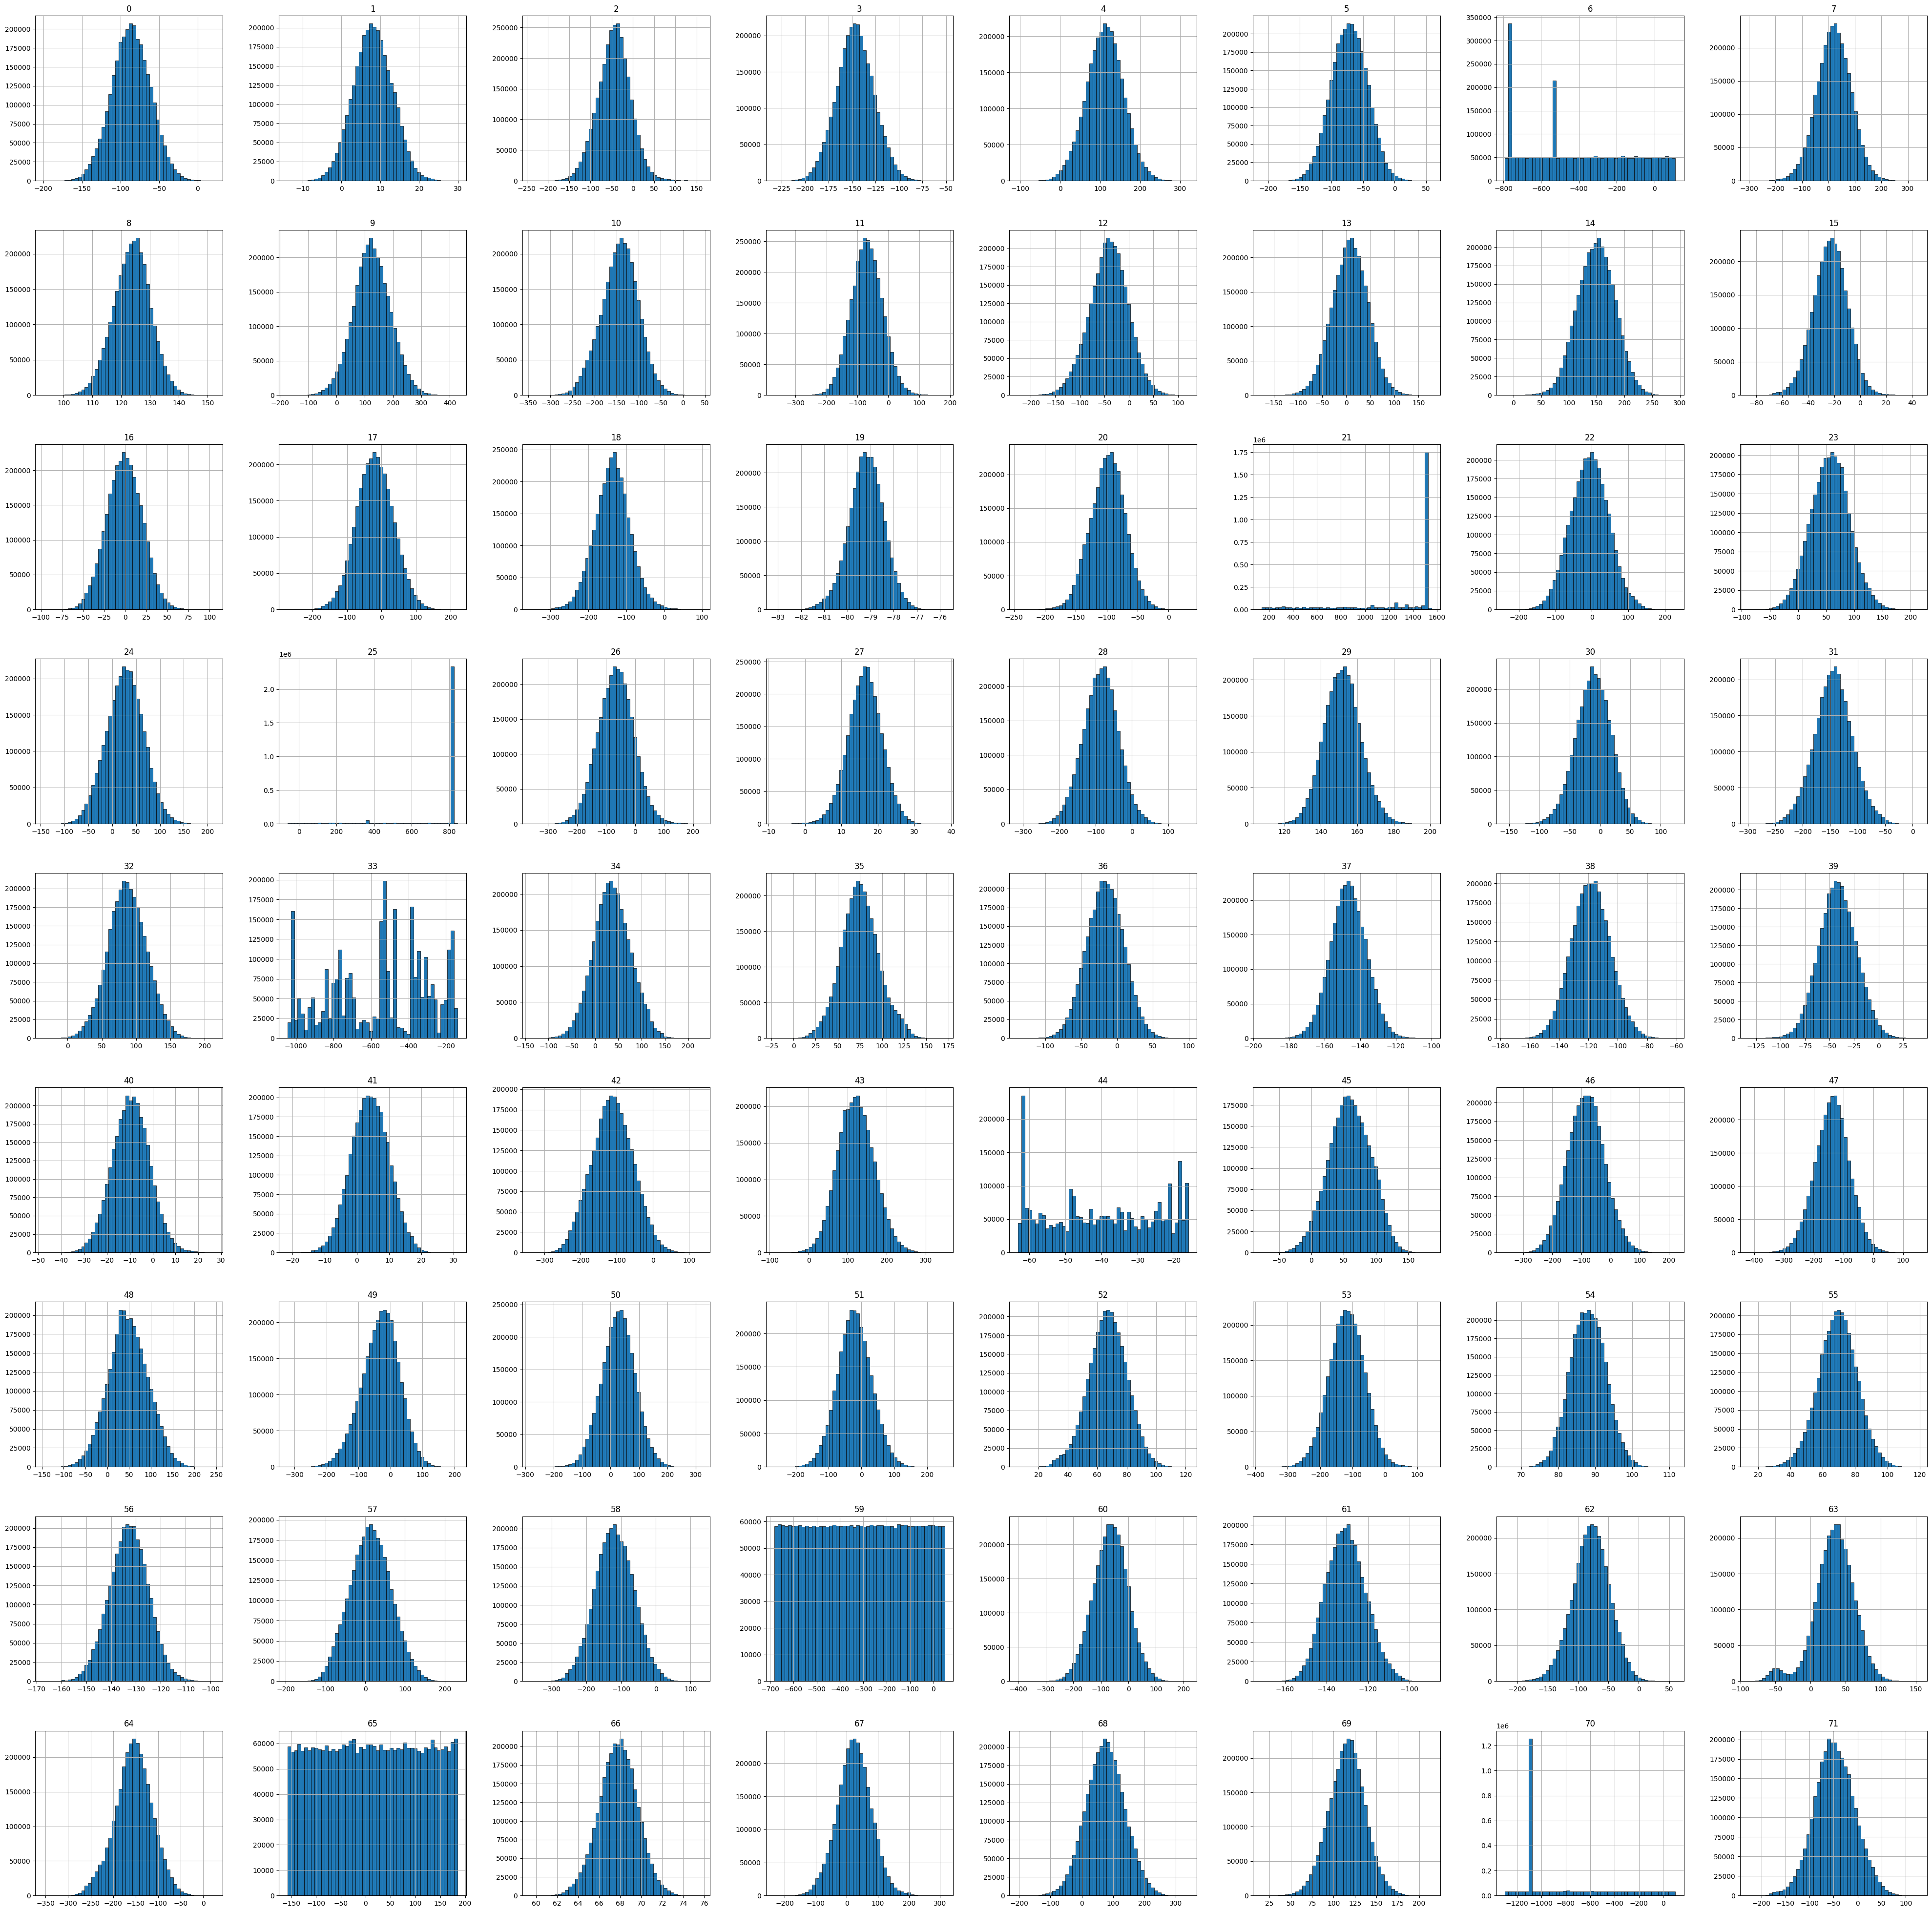

In [152]:


df_base.hist(bins=50, figsize=(50,50), edgecolor='black', linewidth=0.5)
plt.show()

Пропущенные значения и дубликаты в данных не обнаружены. Большая часть данных имеет нормальное распределение, но также есть несбалансированные данные с пиковыми значениями. Проверим данные на корреляцию, мультиколлинеарность. А также построим боксплоты, чтобы проверить признаки на выбросы.


In [153]:
df_base.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,1.000000,-0.018697,0.027923,-0.018087,0.041373,-0.028934,0.003006,-0.005590,-0.000954,-0.006815,0.023097,0.010099,-0.022845,-0.023425,0.019311,-0.016958,-0.017863,-0.010239,0.011397,0.017781,0.037180,0.018493,0.027163,-0.044280,0.004687,0.045019,-0.009101,0.012514,-0.004652,0.002517,-0.042372,-0.043339,-0.002752,0.033086,0.002972,-0.029769,0.038084,0.008013,-0.005601,-0.008921,0.032631,-0.031545,0.023595,0.016180,0.001762,0.038761,-0.008306,0.023702,-0.040801,-0.002809,-0.000773,0.013148,0.046587,-0.018750,-0.016265,-0.019364,0.018162,0.063266,0.000227,0.000407,-0.012306,0.041890,-0.019047,0.040108,0.007845,0.003051,0.002094,0.027372,-0.008185,-0.019688,-0.021204,0.025474
1,-0.018697,1.000000,0.003489,0.009516,-0.020742,0.033579,0.011875,0.045928,0.004558,-0.036872,-0.073076,-0.032219,-0.013173,0.027931,-0.055133,0.062157,0.061852,-0.045343,0.008219,-0.025666,-0.054544,0.027760,-0.073152,0.017950,0.057634,0.002096,-0.012388,-0.009393,0.026895,-0.054487,0.050817,0.005163,-0.051761,0.026395,-0.026768,0.094630,-0.058088,-0.040804,-0.003273,0.002685,-0.037083,-0.038649,-0.046377,-0.028716,0.069395,0.034281,0.005295,0.017191,0.065112,0.014761,0.003738,-0.001708,-0.011019,0.028869,0.007554,0.024546,-0.044561,-0.096130,-0.014113,-0.000058,-0.031524,-0.035945,0.011564,-0.143105,0.009382,0.001380,0.055787,0.013307,-0.016829,0.030559,-0.017286,-0.015989
2,0.027923,0.003489,1.000000,-0.002529,0.004470,-0.053786,-0.001619,0.028222,0.002511,-0.001074,0.009154,-0.016238,-0.025841,0.021162,-0.010818,0.015326,0.025508,0.034773,0.002873,-0.006064,0.015603,0.040736,-0.040690,-0.030233,-0.013013,0.022908,-0.002307,0.006860,-0.006011,-0.027639,-0.008426,-0.019517,-0.009056,-0.015824,-0.036521,0.015467,-0.008119,-0.008318,0.011668,0.006016,-0.003798,-0.005573,0.007058,-0.020831,0.016626,0.023809,0.020972,-0.036845,0.043292,-0.027161,0.026049,-0.005029,0.039143,0.009673,0.015993,0.033355,0.005679,-0.009579,0.022710,-0.000767,-0.038005,-0.028917,-0.014118,0.017518,0.062886,0.001544,-0.027636,-0.000426,-0.037688,0.041420,0.009732,-0.042930
3,-0.018087,0.009516,-0.002529,1.000000,-0.007023,-0.002381,-0.000333,-0.001561,-0.014474,-0.011116,0.026432,-0.011853,-0.018399,-0.009245,0.020173,-0.002637,0.023142,0.011561,0.014114,0.003432,-0.002894,-0.037336,0.038242,-0.005994,0.008507,-0.014488,0.003505,-0.024557,0.036246,0.014288,0.028092,0.017625,0.025137,-0.010452,0.037633,-0.011120,0.025119,0.020288,-0.013526,-0.009155,0.033361,-0.003531,0.030520,0.020818,-0.004056,-0.011060,0.014299,-0.007456,-0.022798,0.020127,-0.014210,-0.004721,-0.050027,0.000613,-0.018196,0.012911,-0.034924,0.032016,-0.020457,0.000282,0.007735,-0.016073,-0.006192,0.021684,-0.003276,0.000453,-0.032467,-0.000672,0.023795,0.011546,-0.009644,-0.005703
4,0.041373,-0.020742,0.004470,-0.007023,1.000000,0.016437,0.002200,-0.014905,-0.003597,0.016579,0.015475,-0.029162,0.008319,0.017426,0.004866,-0.030409,-0.017512,-0.007001,0.001492,-0.012743,0.002689,-0.001216,0.001638,-0.021227,-0.007033,0.018734,-0.023956,-0.003821,-0.020626,-0.016300,0.000385,-0.037523,-0.028398,0.010687,-0.006619,-0.002860,0.021894,0.007947,0.019341,0.007524,0.005811,0.017841,0.002007,-0.020039,0.001624,0.001396,-0.019263,-0.023558,-0.009834,-0.028118,-0.056635,0.022511,0.005732,0.028982,0.007588,0.023967,-0.018694,-0.015901,0.011605,-0.000831,-0.005250,-0.019423,-0.012220,-0.005466,0.024066,0.006467,0.011873,0.023648,0.003213,-0.029733,-0.009048,0.042965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.027372,0.013307,-0.000426,-0.000672,0.023648,0.000202,0.009130,-0.02

In [154]:
df = df_base[:5000]

vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

vif_data.sort_values(by='VIF', ascending=False).head(25)

,feature,VIF
19,19,2691.446311
66,66,1260.546735
8,8,358.230886
54,54,337.380540
56,56,288.956516
29,29,226.370689
37,37,225.027367
61,61,205.363283
38,38,83.707091
3,3,54.719422


Результаты указывают на наличие высоких значений VIF для некоторых признаков. Высокие значения VIF свидетельствуют о том, что эти признаки сильно коррелируют с другими признаками в наборе данных.\
- Признаки с очень высоким VIF (>1000):

19: VIF = 2691.446100\
66: VIF = 1260.547198
- Признаки с высоким VIF (100 < VIF < 1000):

8: VIF = 358.230826\
54: VIF = 337.380566\
56: VIF = 288.956516\
29: VIF = 226.370760\
37: VIF = 225.027367\
61: VIF = 205.363283
- Также присутствует много признаков с умеренно высоким VIF (10 < VIF < 100)

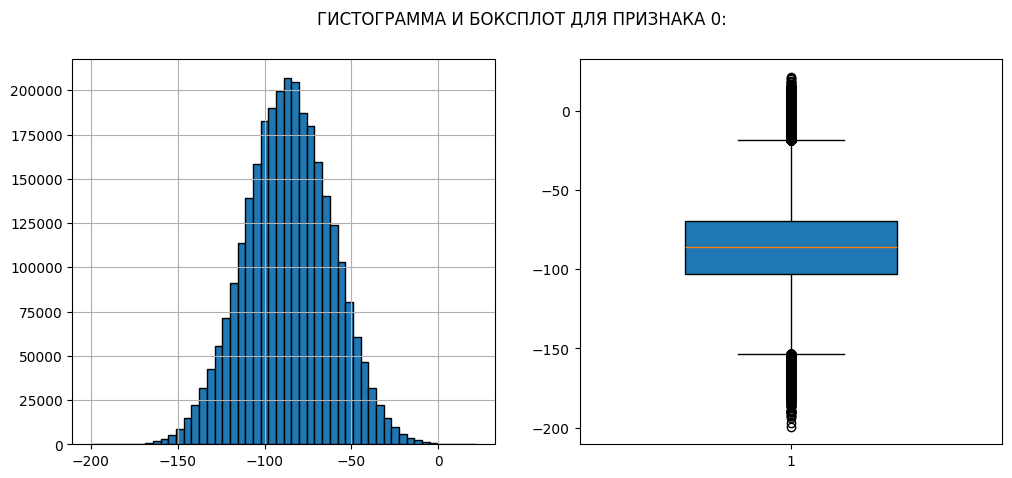

Пороговые значения признака 0:
Нижняя граница значений: -153.78
Верхняя граница значений: -18.54


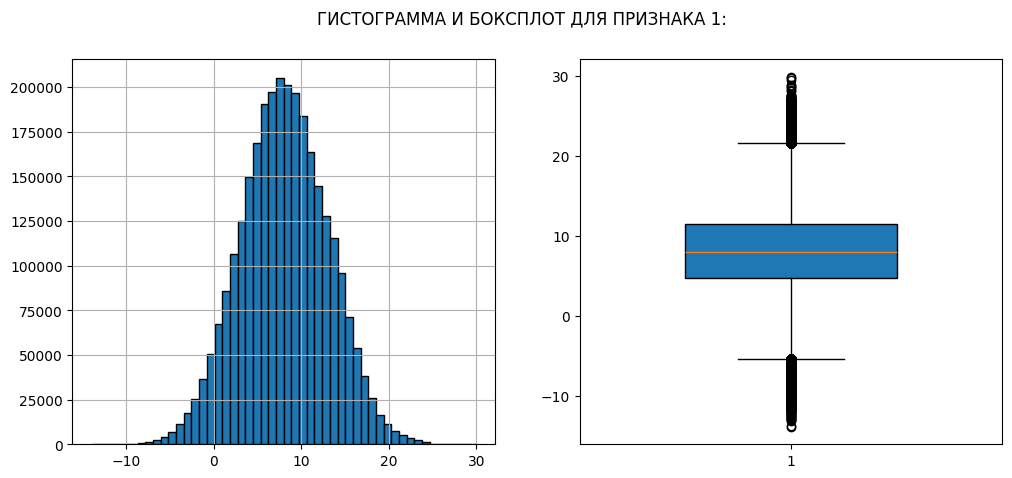

Пороговые значения признака 1:
Нижняя граница значений: -5.43
Верхняя граница значений: 21.61


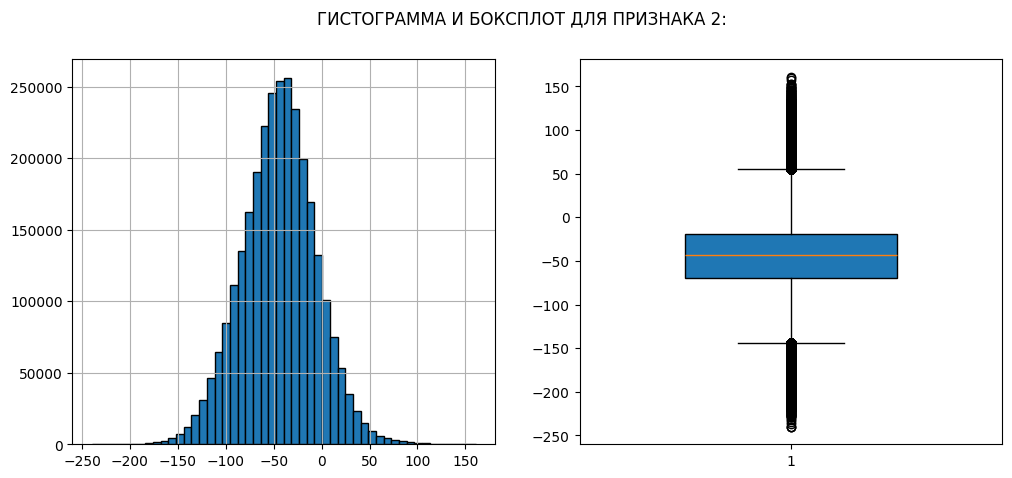

Пороговые значения признака 2:
Нижняя граница значений: -144.46
Верхняя граница значений: 55.28


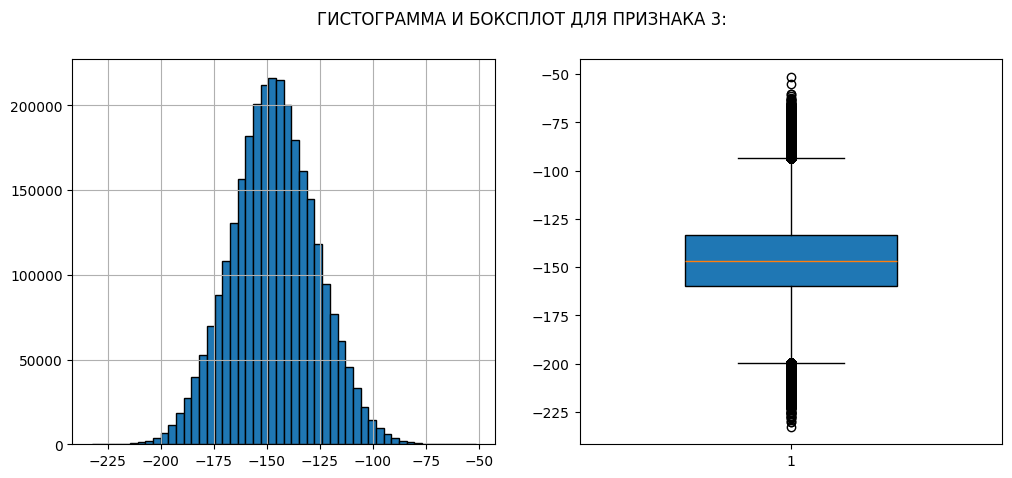

Пороговые значения признака 3:
Нижняя граница значений: -199.77
Верхняя граница значений: -93.46


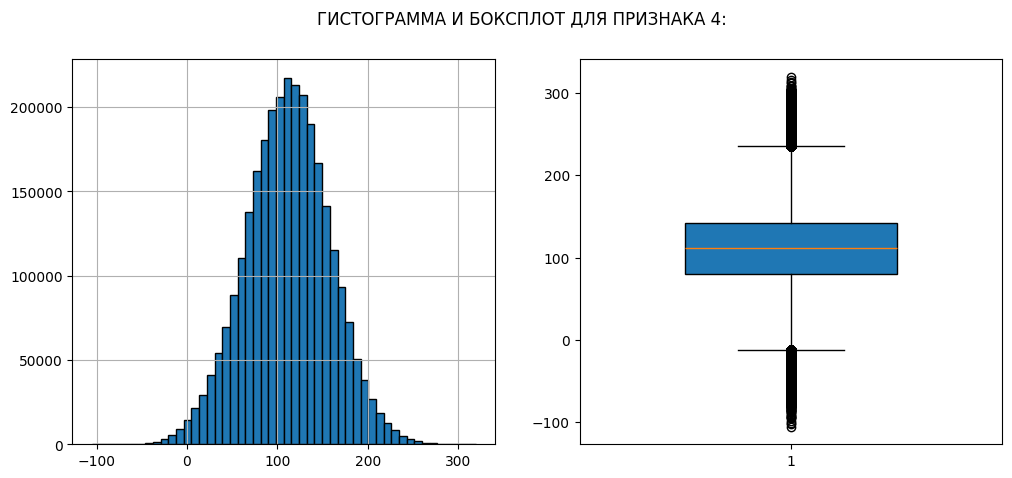

Пороговые значения признака 4:
Нижняя граница значений: -12.29
Верхняя граница значений: 235.17


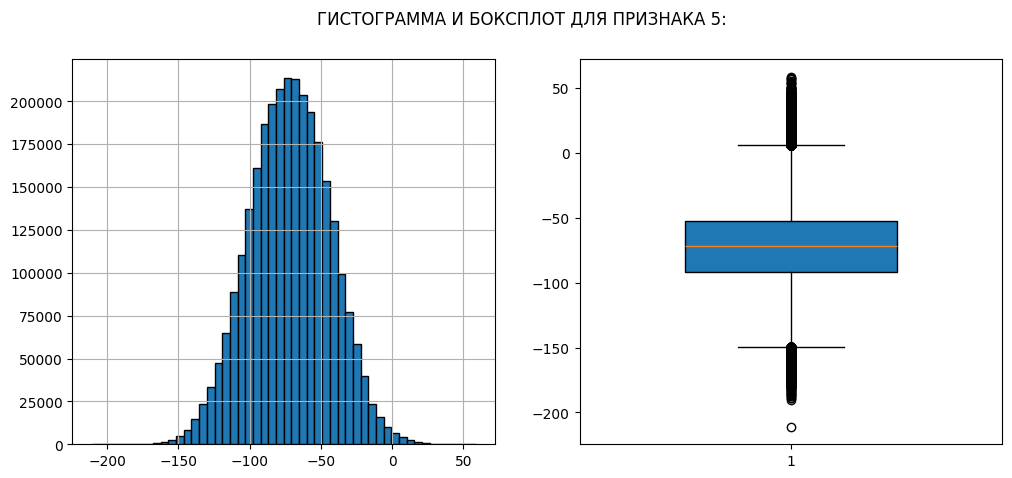

Пороговые значения признака 5:
Нижняя граница значений: -149.79
Верхняя граница значений: 5.97


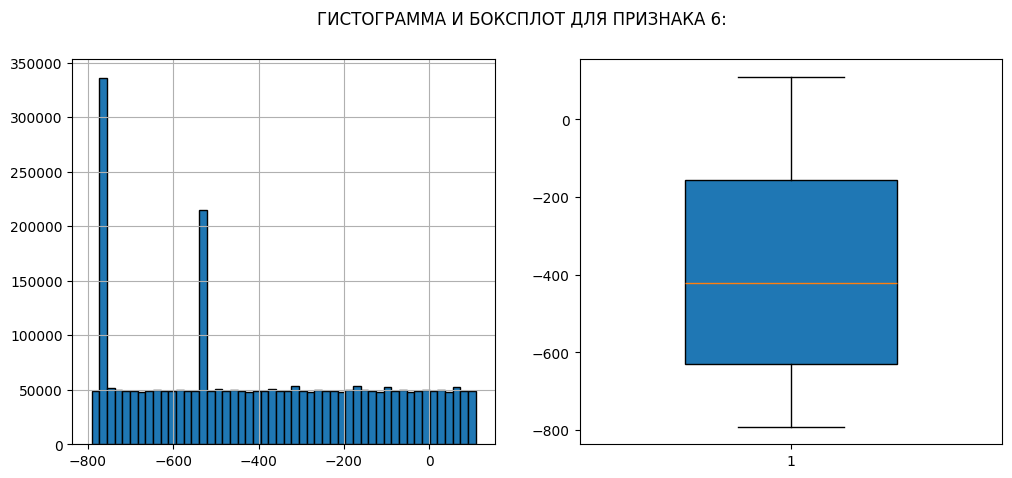

Пороговые значения признака 6:
Нижняя граница значений: -1338.33
Верхняя граница значений: 552.33


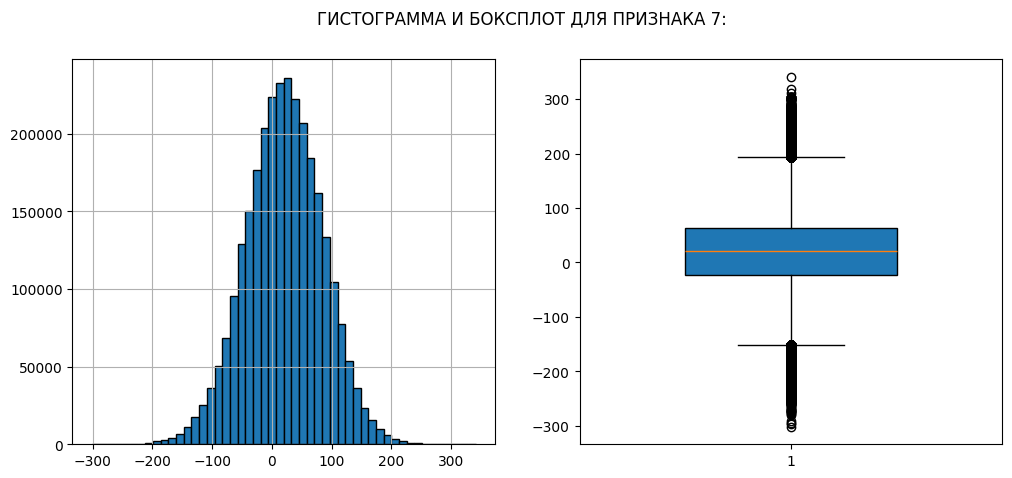

Пороговые значения признака 7:
Нижняя граница значений: -151.43
Верхняя граница значений: 193.13


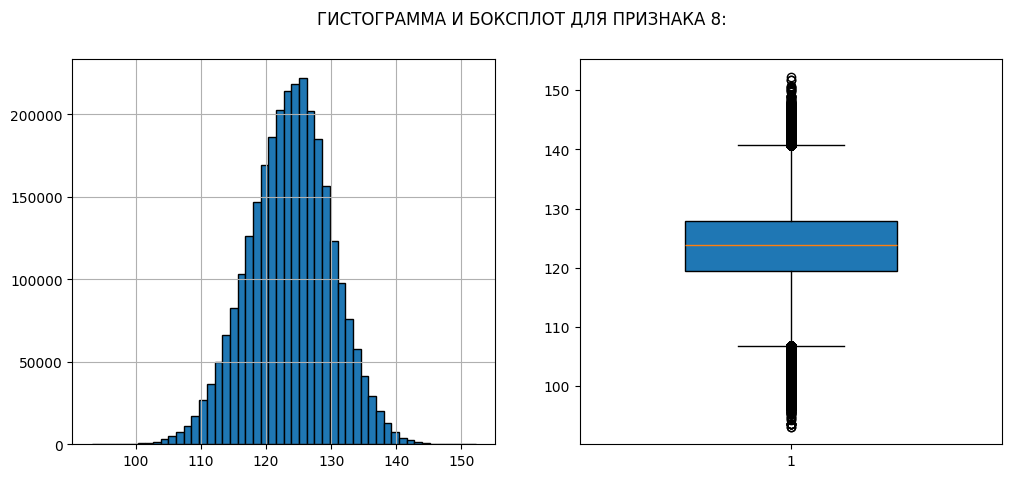

Пороговые значения признака 8:
Нижняя граница значений: 106.75
Верхняя граница значений: 140.7


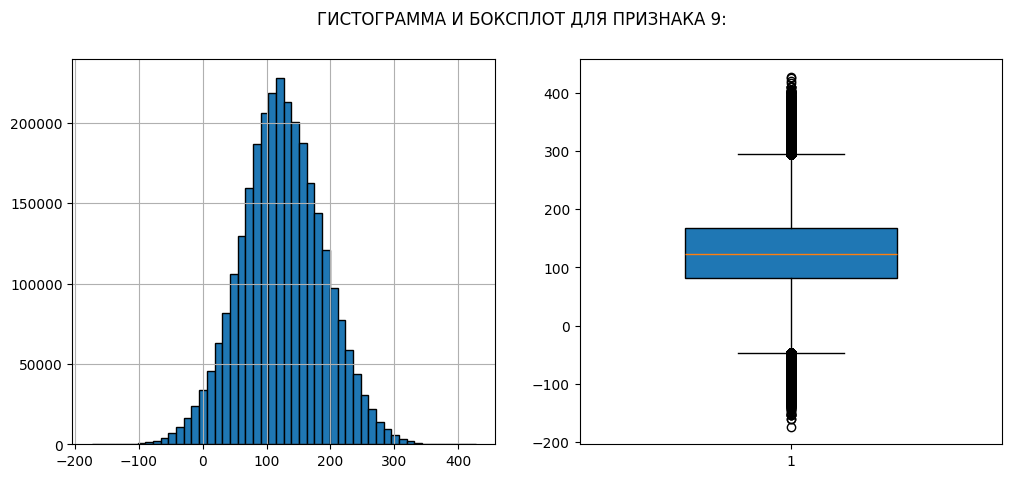

Пороговые значения признака 9:
Нижняя граница значений: -46.41
Верхняя граница значений: 295.4


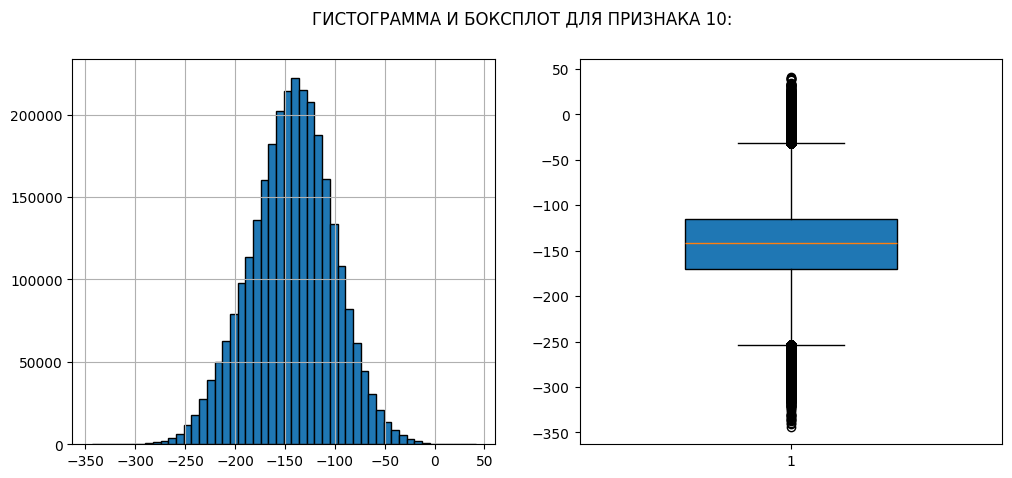

Пороговые значения признака 10:
Нижняя граница значений: -253.31
Верхняя граница значений: -31.99


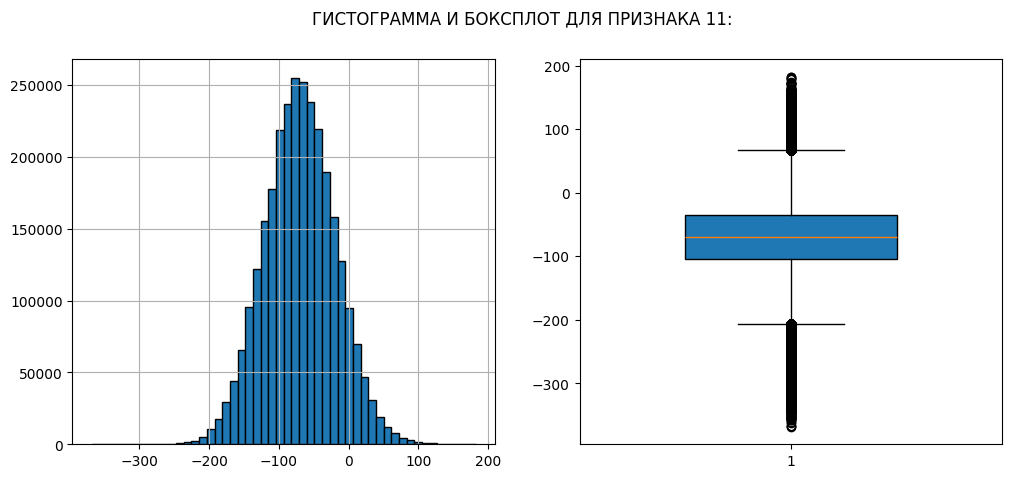

Пороговые значения признака 11:
Нижняя граница значений: -206.54
Верхняя граница значений: 66.81


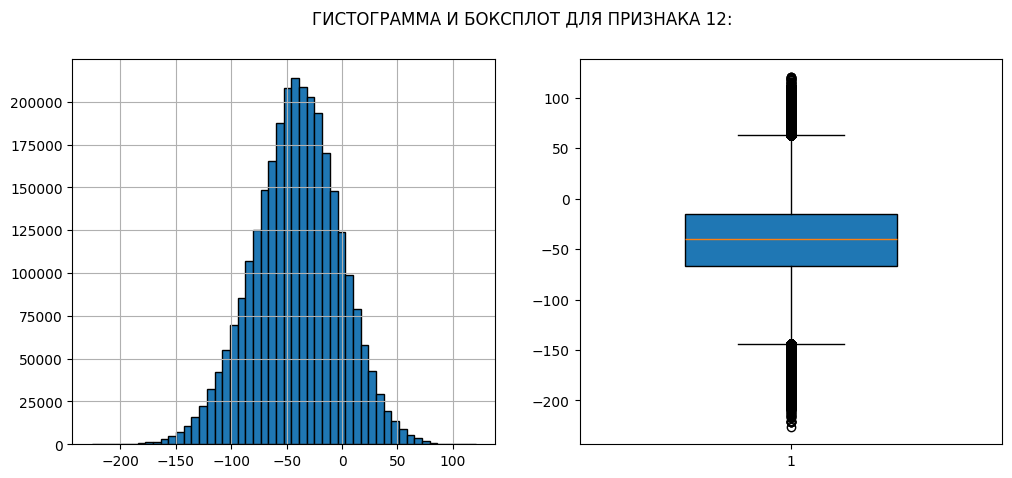

Пороговые значения признака 12:
Нижняя граница значений: -144.31
Верхняя граница значений: 62.85


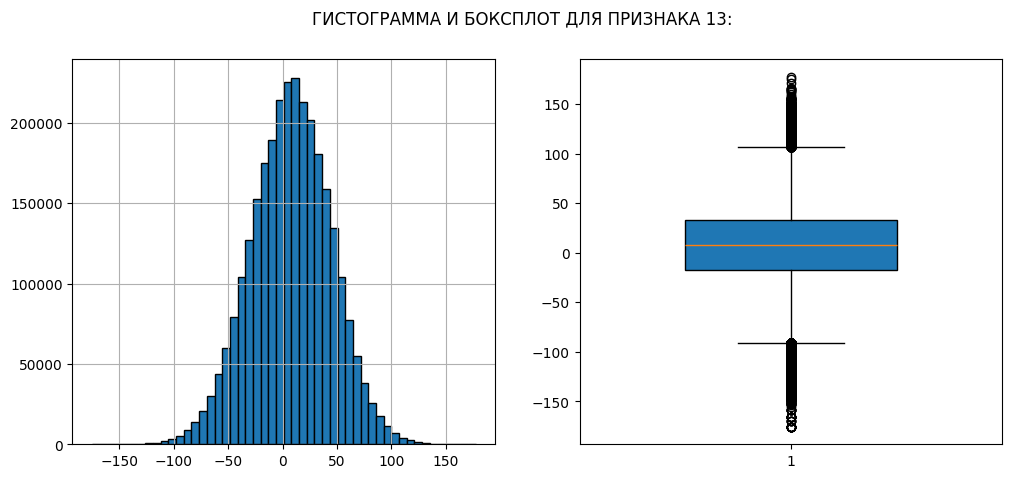

Пороговые значения признака 13:
Нижняя граница значений: -91.37
Верхняя граница значений: 107.09


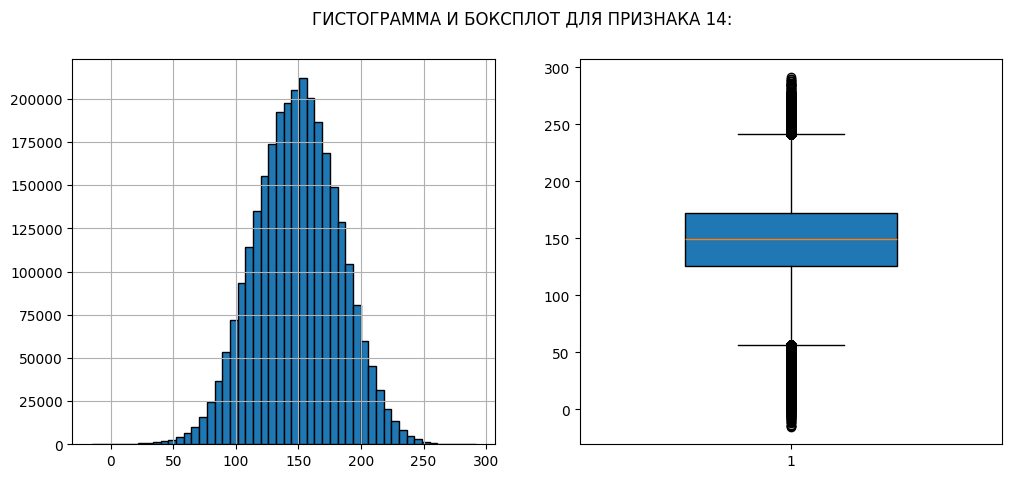

Пороговые значения признака 14:
Нижняя граница значений: 56.67
Верхняя граница значений: 241.46


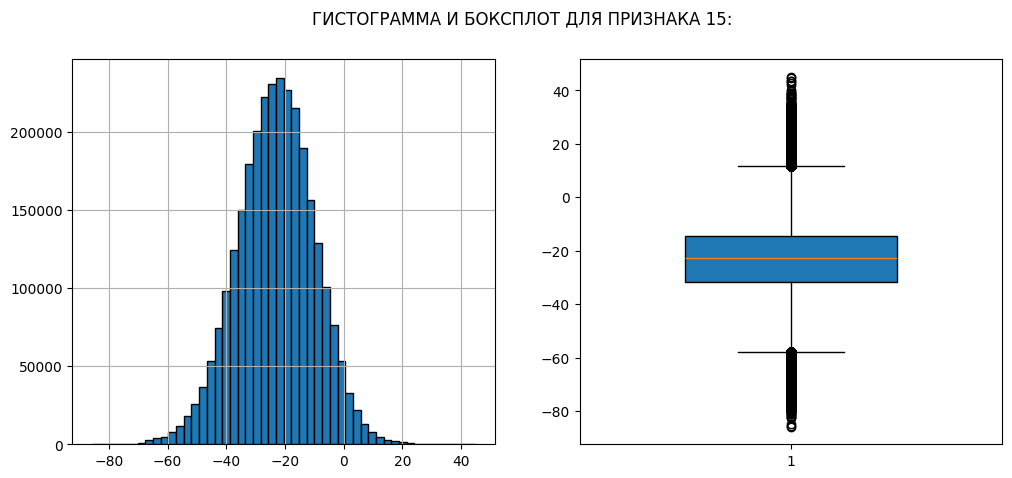

Пороговые значения признака 15:
Нижняя граница значений: -57.91
Верхняя граница значений: 11.79


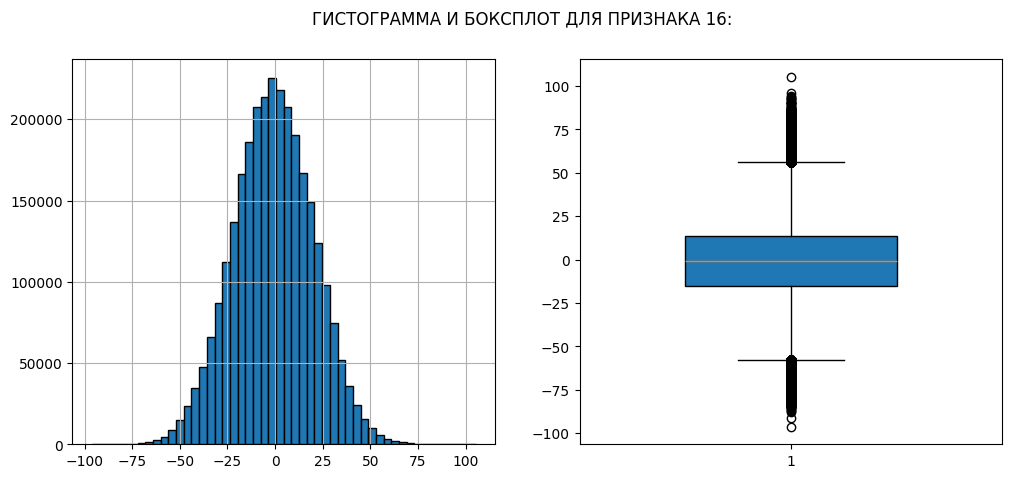

Пороговые значения признака 16:
Нижняя граница значений: -57.95
Верхняя граница значений: 56.17


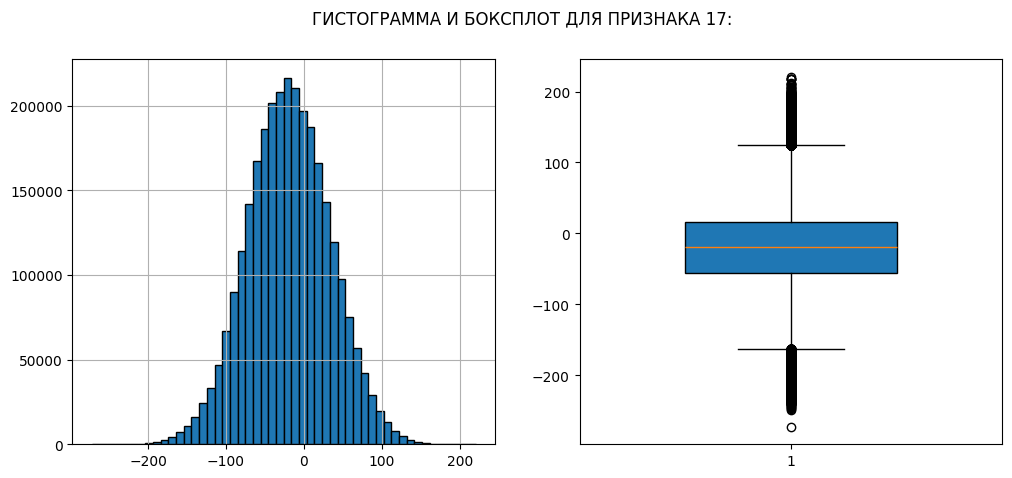

Пороговые значения признака 17:
Нижняя граница значений: -163.55
Верхняя граница значений: 124.67


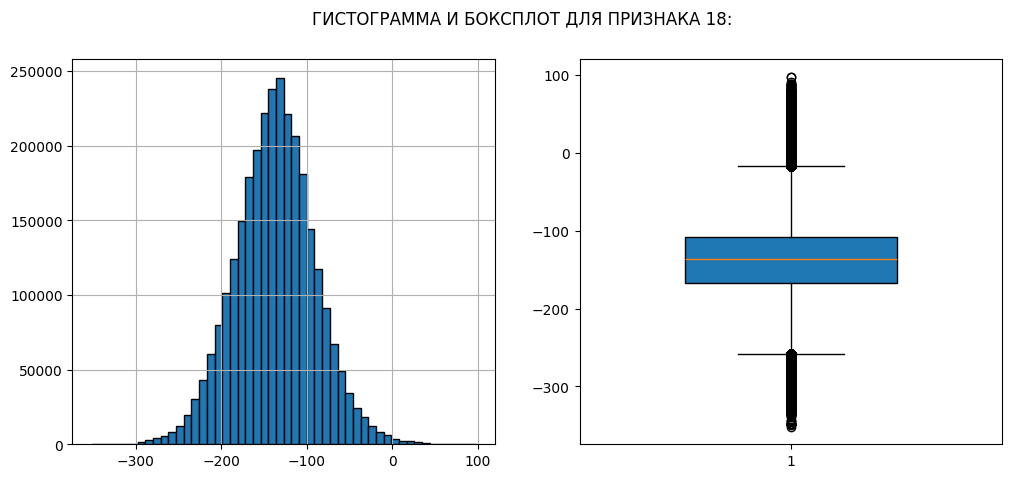

Пороговые значения признака 18:
Нижняя граница значений: -257.66
Верхняя граница значений: -17.47


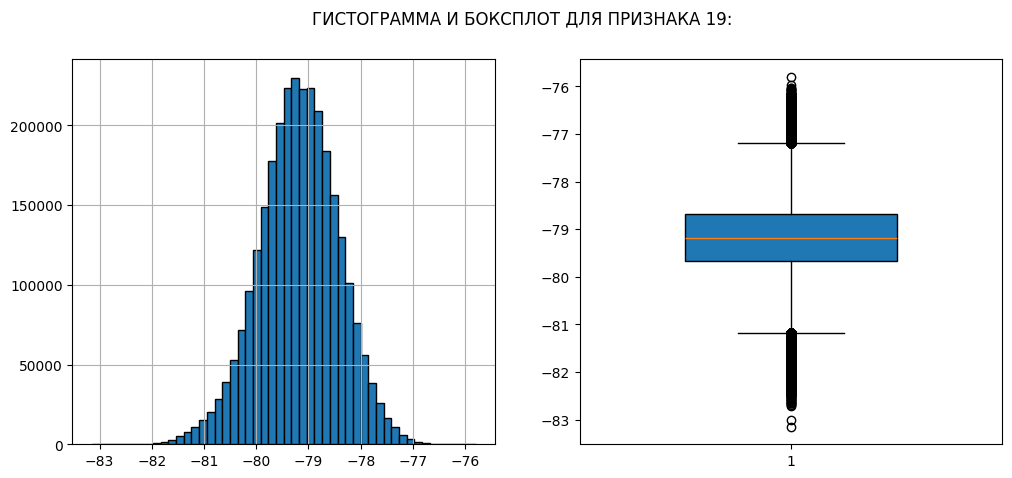

Пороговые значения признака 19:
Нижняя граница значений: -81.18
Верхняя граница значений: -77.18


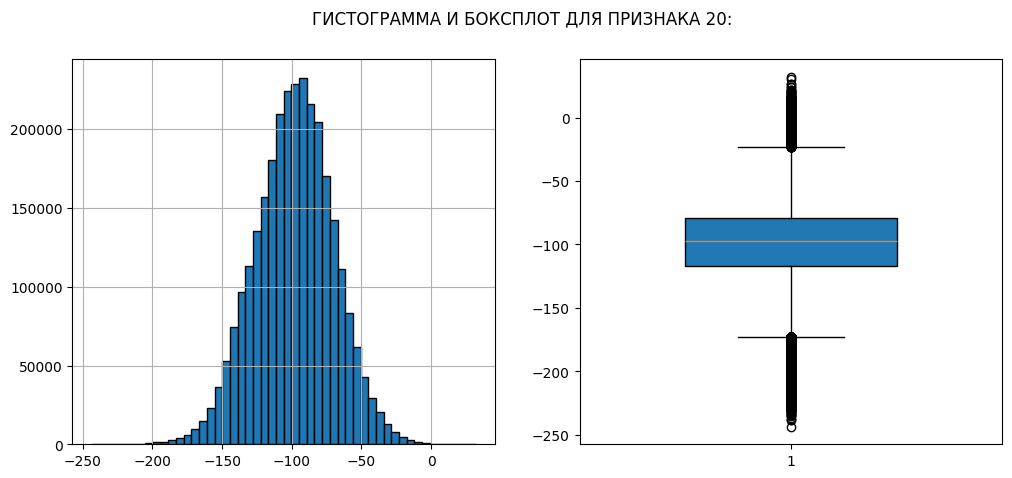

Пороговые значения признака 20:
Нижняя граница значений: -173.24
Верхняя граница значений: -22.84


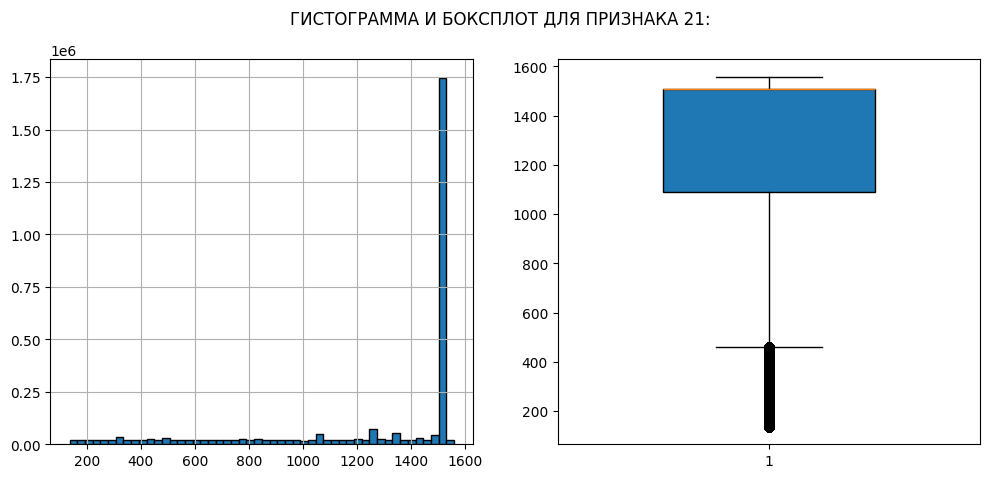

Пороговые значения признака 21:
Нижняя граница значений: 460.64
Верхняя граница значений: 2135.18


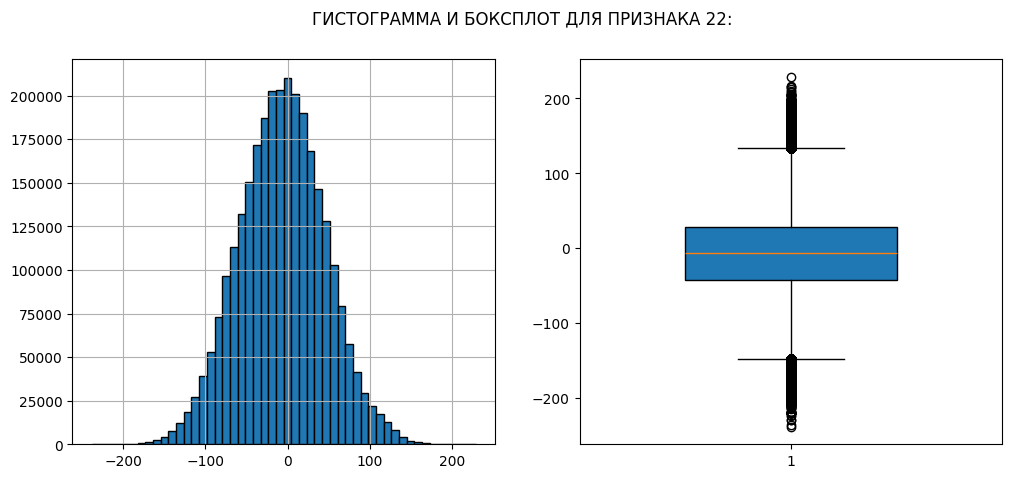

Пороговые значения признака 22:
Нижняя граница значений: -147.96
Верхняя граница значений: 133.94


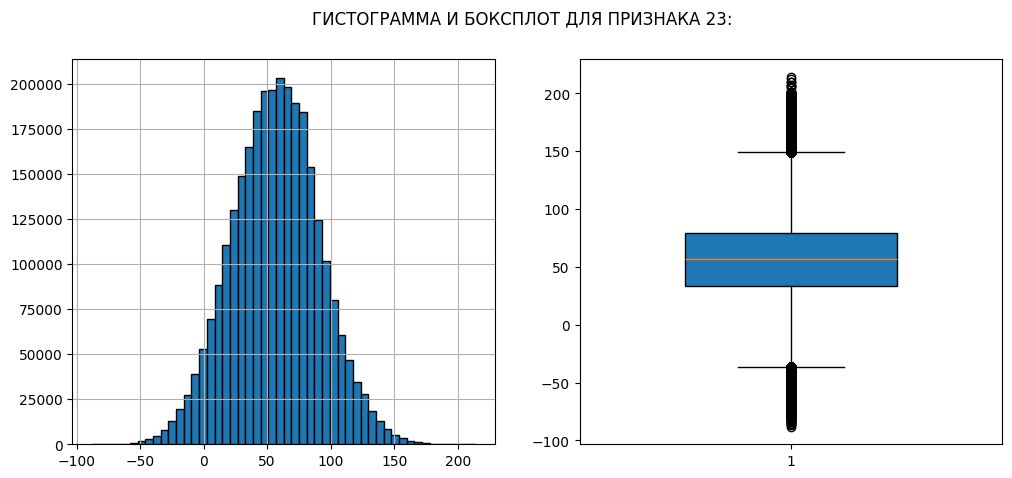

Пороговые значения признака 23:
Нижняя граница значений: -36.26
Верхняя граница значений: 149.22


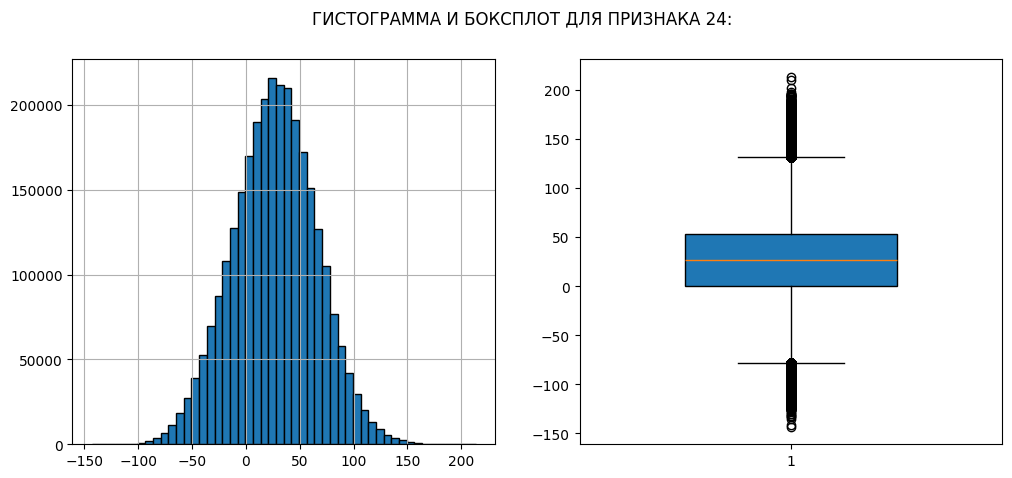

Пороговые значения признака 24:
Нижняя граница значений: -78.24
Верхняя граница значений: 131.89


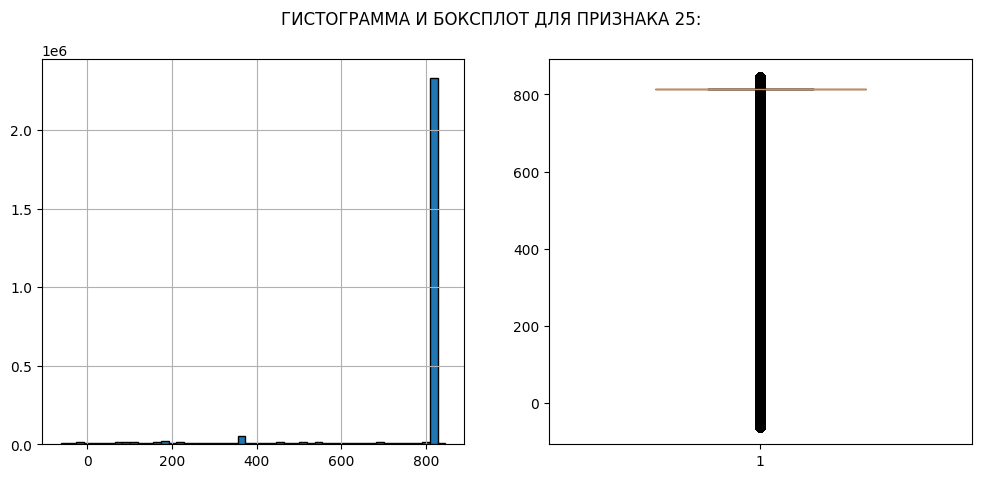

Пороговые значения признака 25:
Нижняя граница значений: 813.77
Верхняя граница значений: 813.77


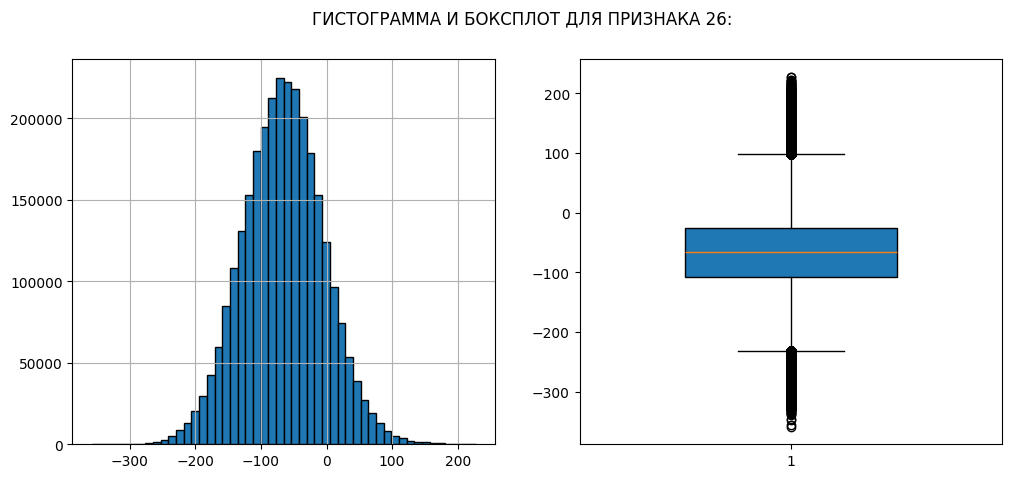

Пороговые значения признака 26:
Нижняя граница значений: -231.27
Верхняя граница значений: 97.84


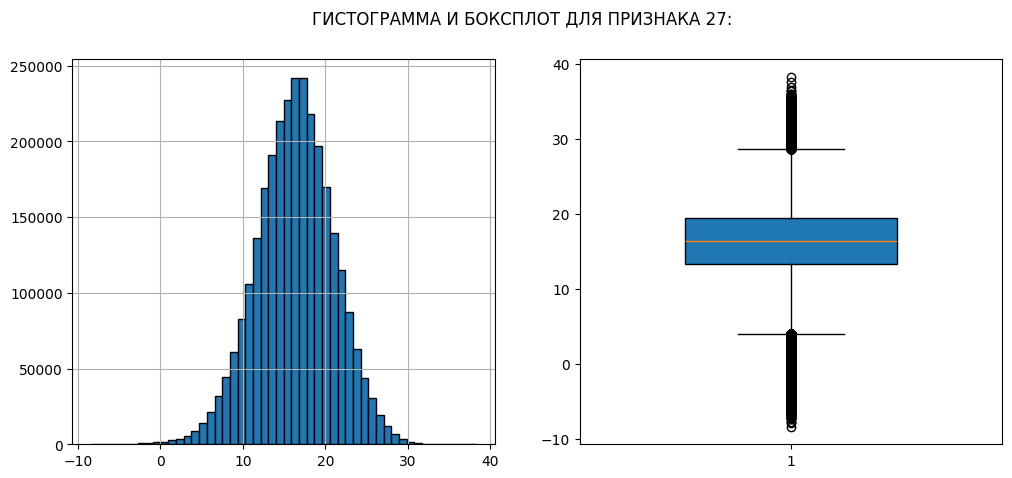

Пороговые значения признака 27:
Нижняя граница значений: 4.0
Верхняя граница значений: 28.7


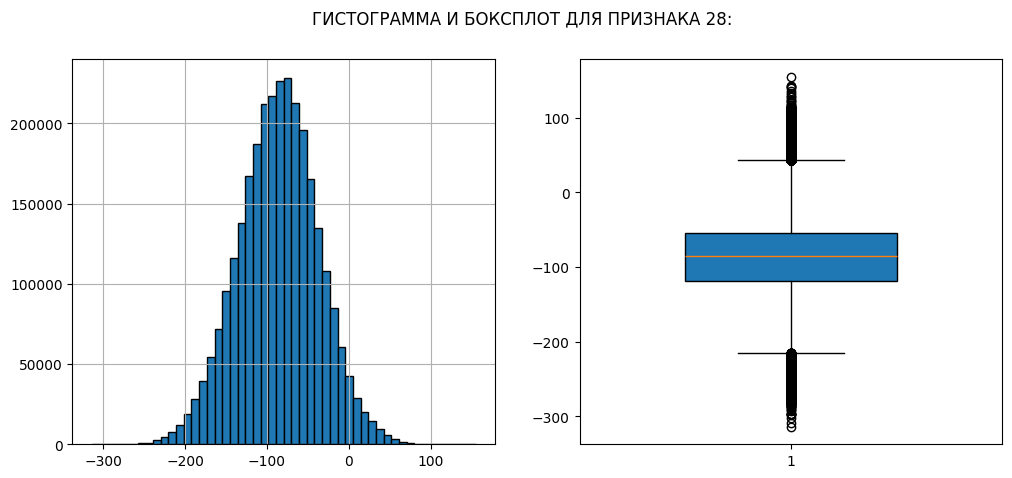

Пороговые значения признака 28:
Нижняя граница значений: -215.83
Верхняя граница значений: 43.3


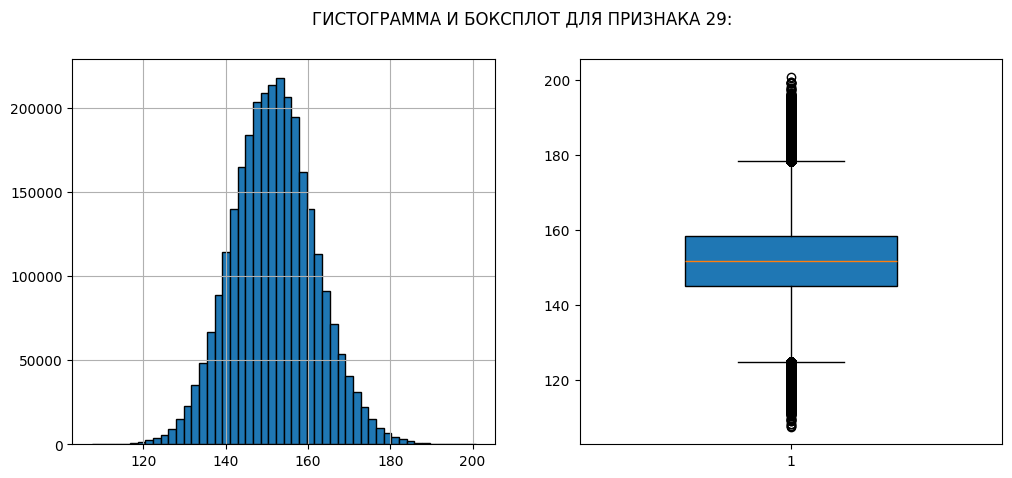

Пороговые значения признака 29:
Нижняя граница значений: 124.8
Верхняя граница значений: 178.36


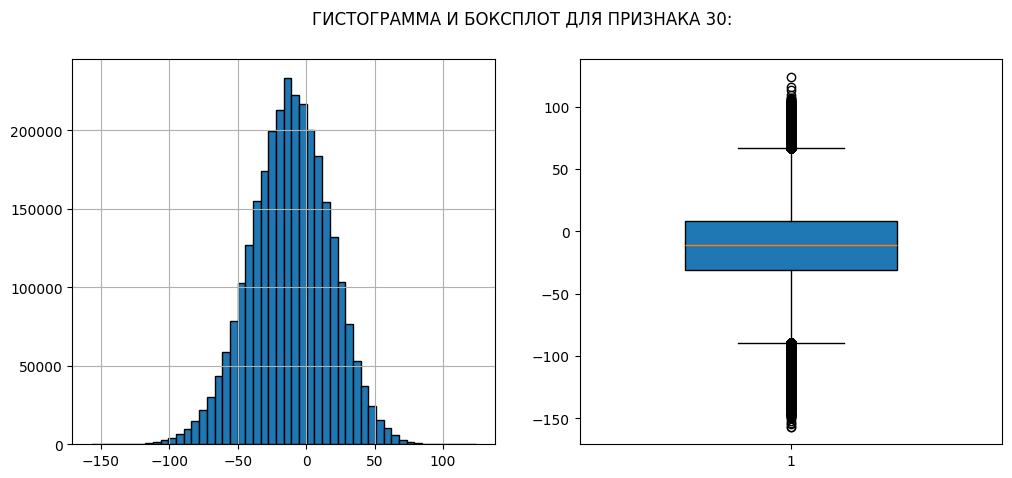

Пороговые значения признака 30:
Нижняя граница значений: -89.33
Верхняя граница значений: 66.87


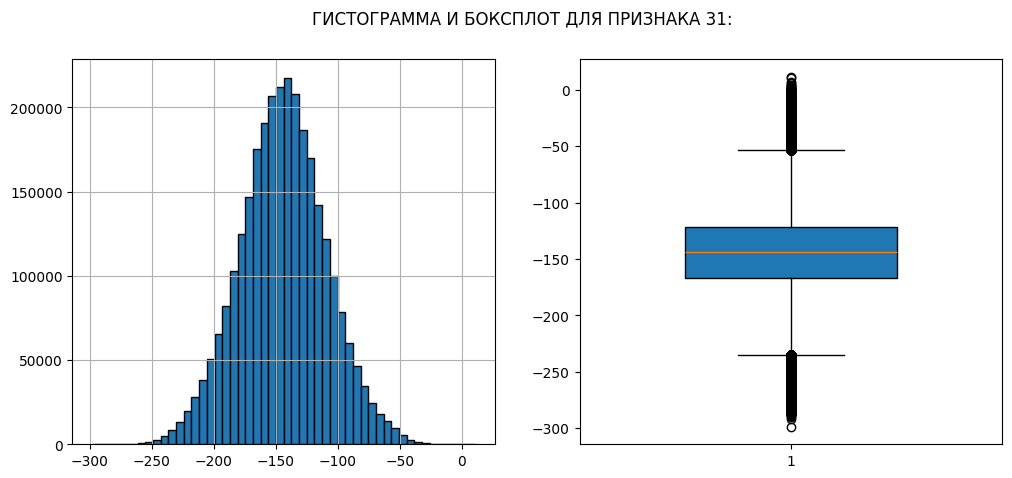

Пороговые значения признака 31:
Нижняя граница значений: -235.4
Верхняя граница значений: -53.11


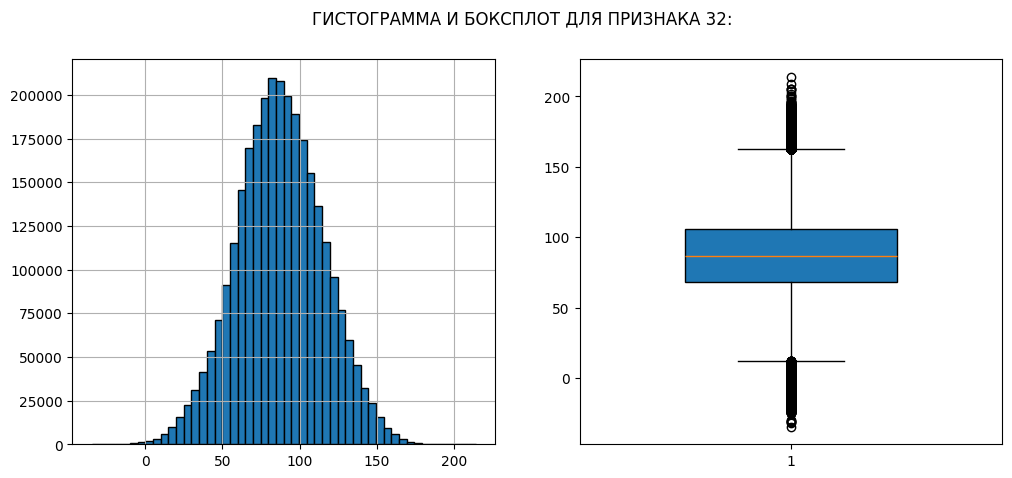

Пороговые значения признака 32:
Нижняя граница значений: 11.73
Верхняя граница значений: 162.58


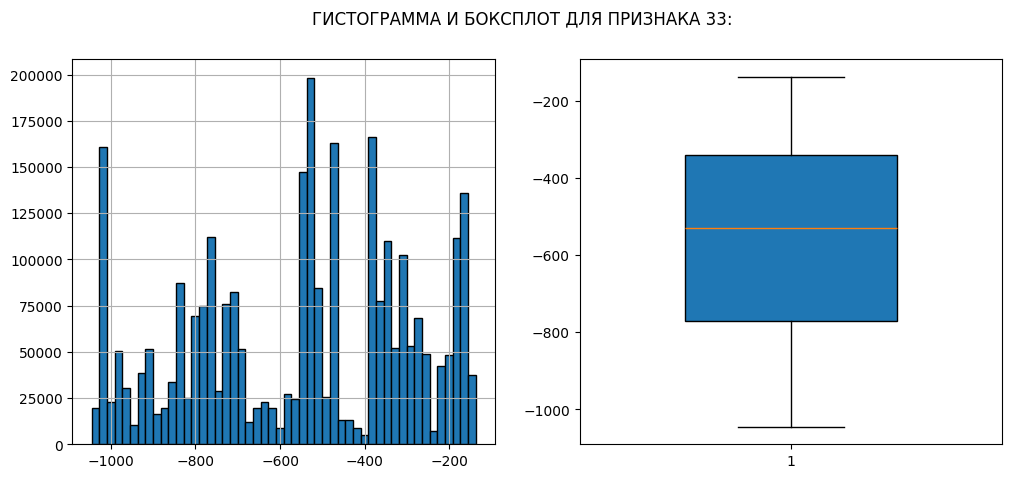

Пороговые значения признака 33:
Нижняя граница значений: -1415.57
Верхняя граница значений: 302.49


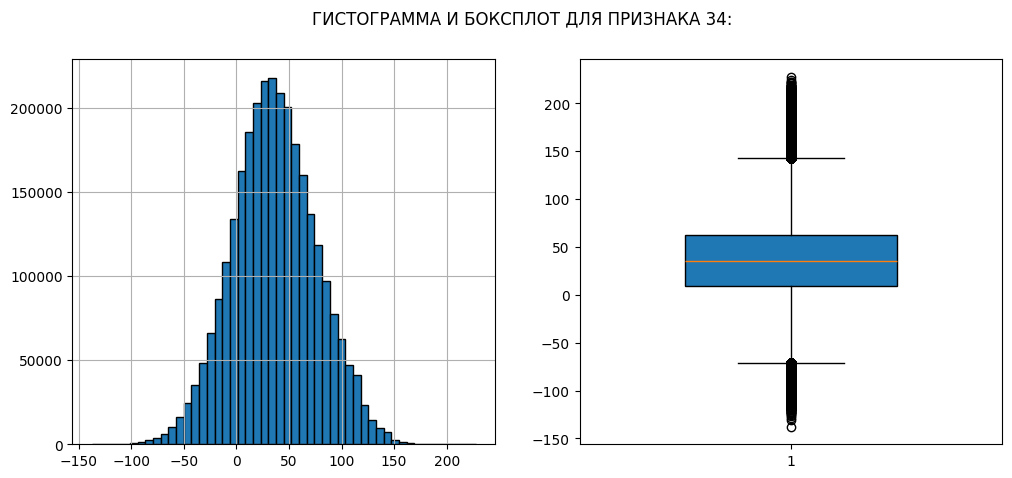

Пороговые значения признака 34:
Нижняя граница значений: -70.93
Верхняя граница значений: 143.14


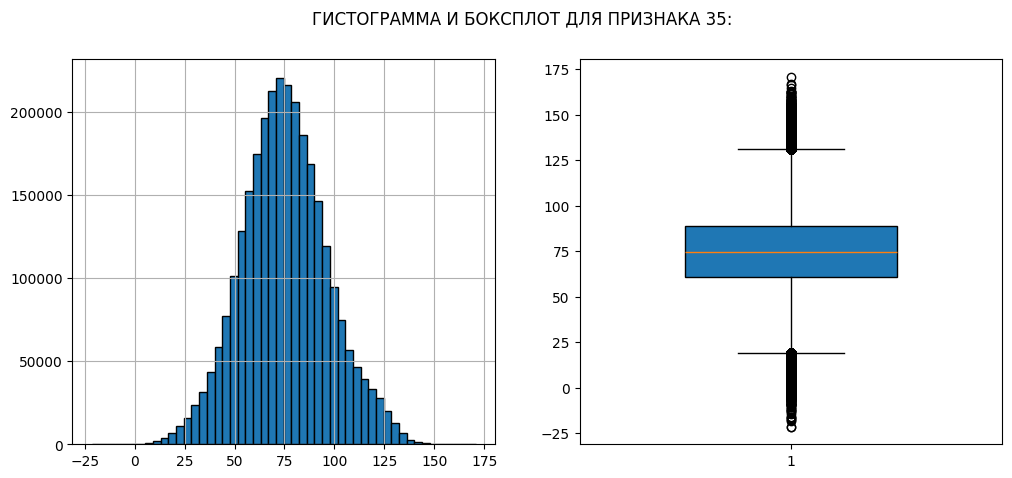

Пороговые значения признака 35:
Нижняя граница значений: 18.97
Верхняя граница значений: 130.81


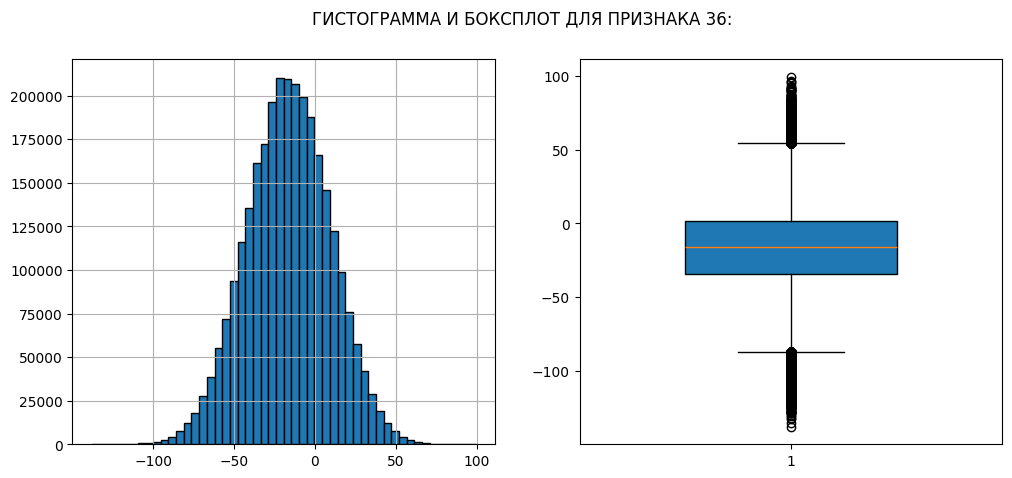

Пороговые значения признака 36:
Нижняя граница значений: -87.19
Верхняя граница значений: 54.26


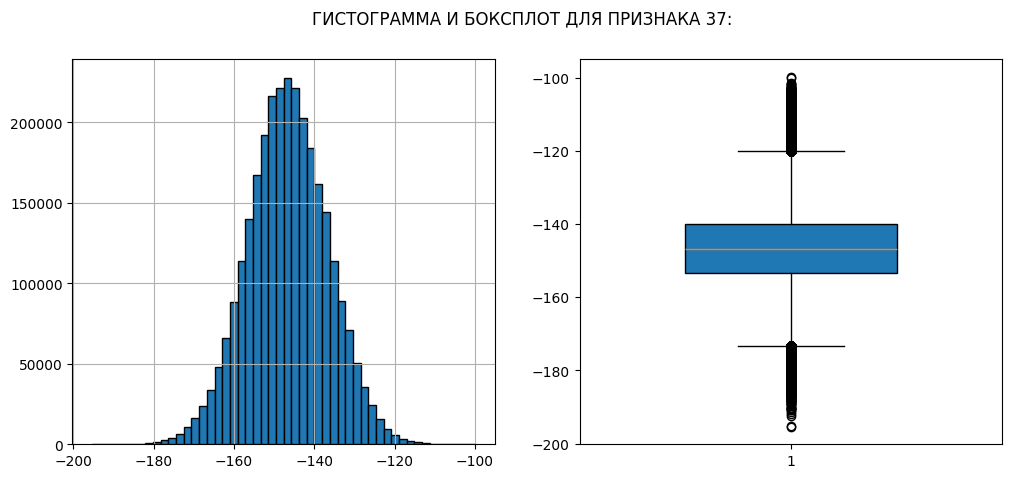

Пороговые значения признака 37:
Нижняя граница значений: -173.24
Верхняя граница значений: -119.98


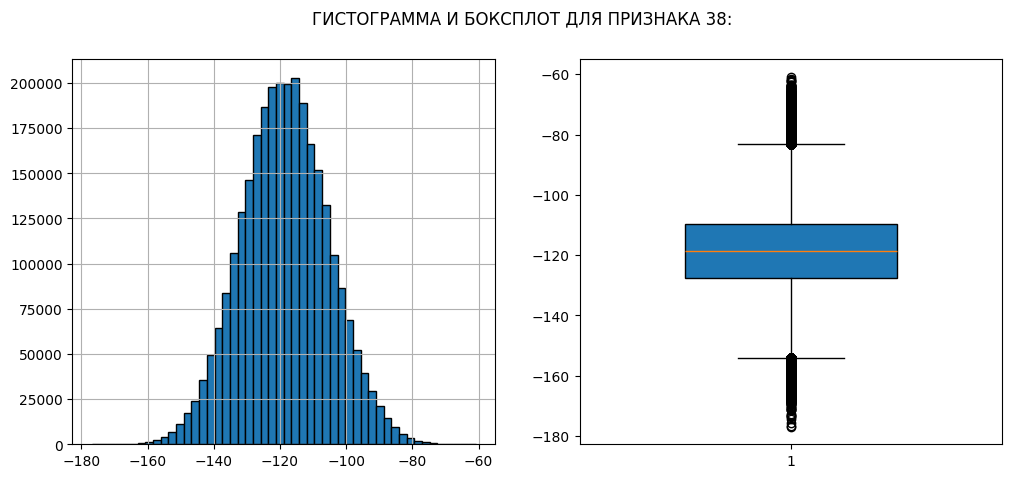

Пороговые значения признака 38:
Нижняя граница значений: -154.11
Верхняя граница значений: -83.01


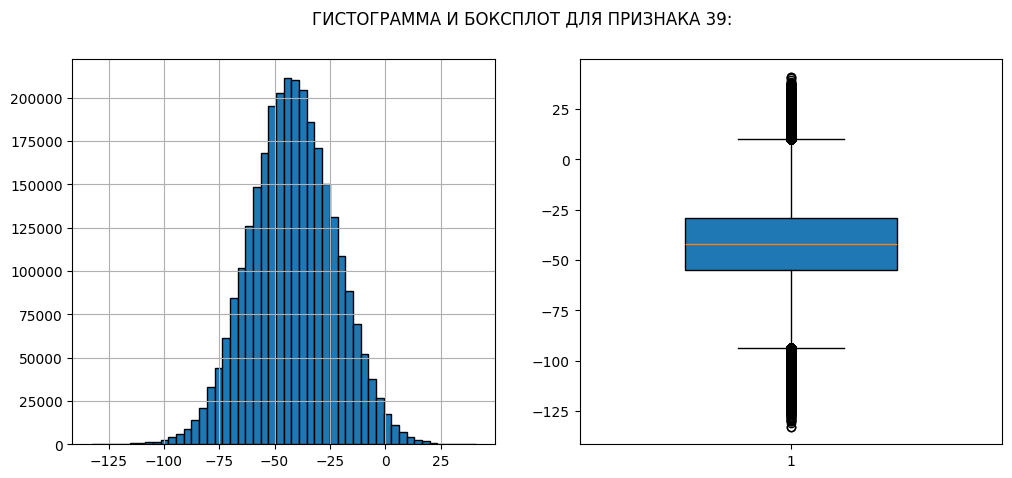

Пороговые значения признака 39:
Нижняя граница значений: -93.6
Верхняя граница значений: 9.89


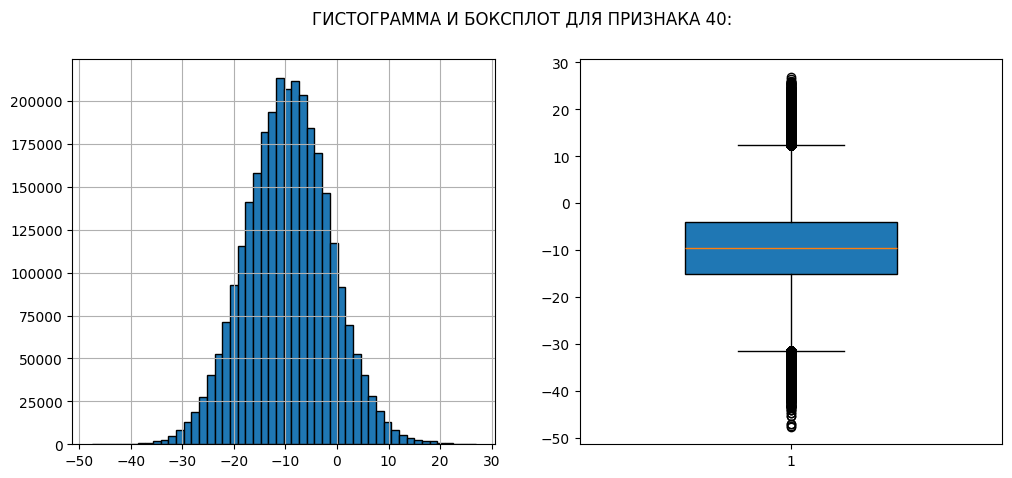

Пороговые значения признака 40:
Нижняя граница значений: -31.44
Верхняя граница значений: 12.44


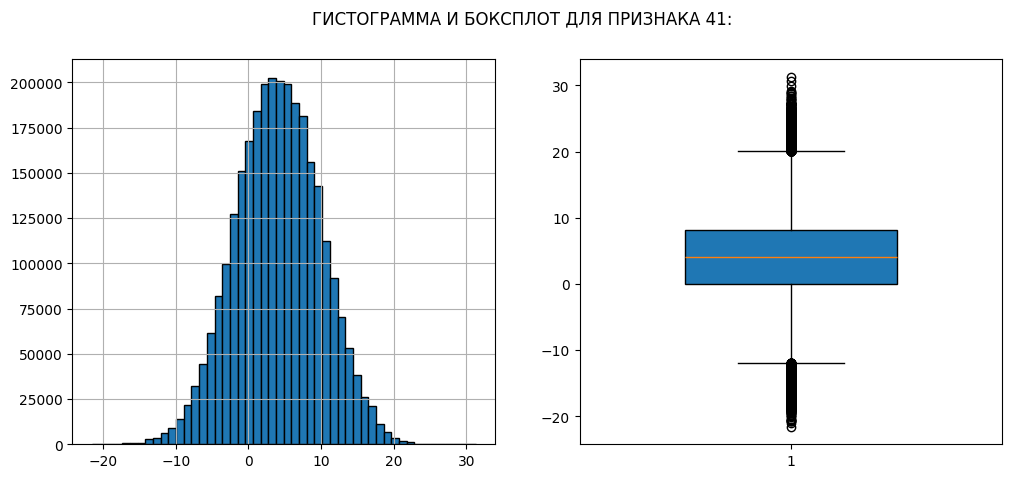

Пороговые значения признака 41:
Нижняя граница значений: -12.02
Верхняя граница значений: 20.13


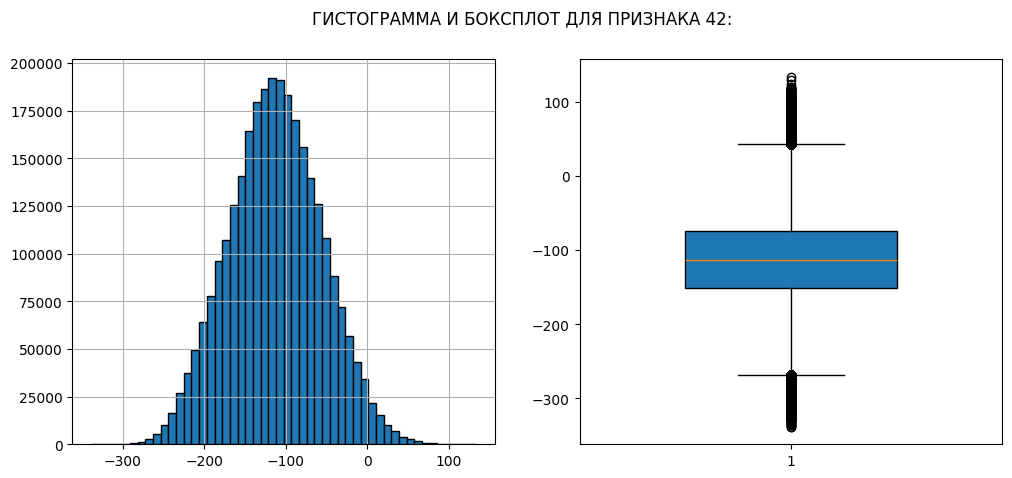

Пороговые значения признака 42:
Нижняя граница значений: -268.27
Верхняя граница значений: 42.87


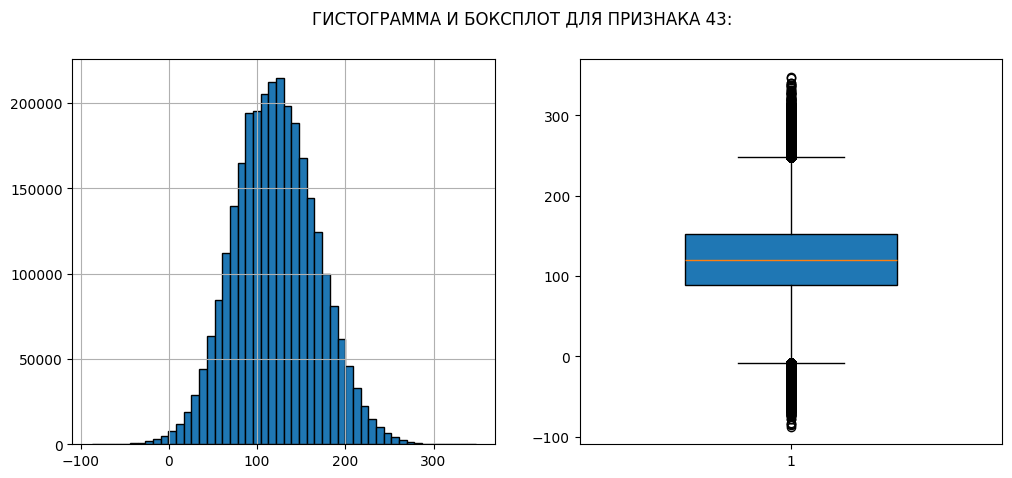

Пороговые значения признака 43:
Нижняя граница значений: -7.85
Верхняя граница значений: 248.29


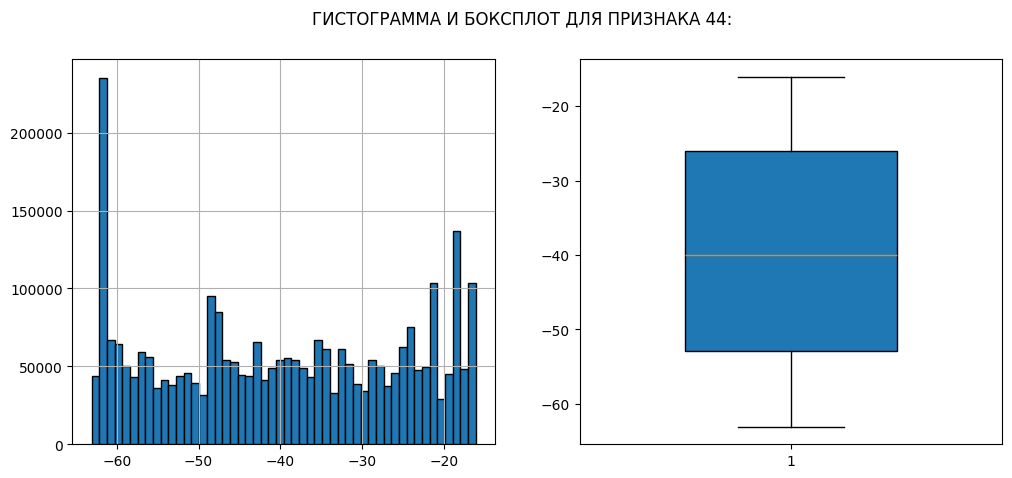

Пороговые значения признака 44:
Нижняя граница значений: -93.22
Верхняя граница значений: 14.37


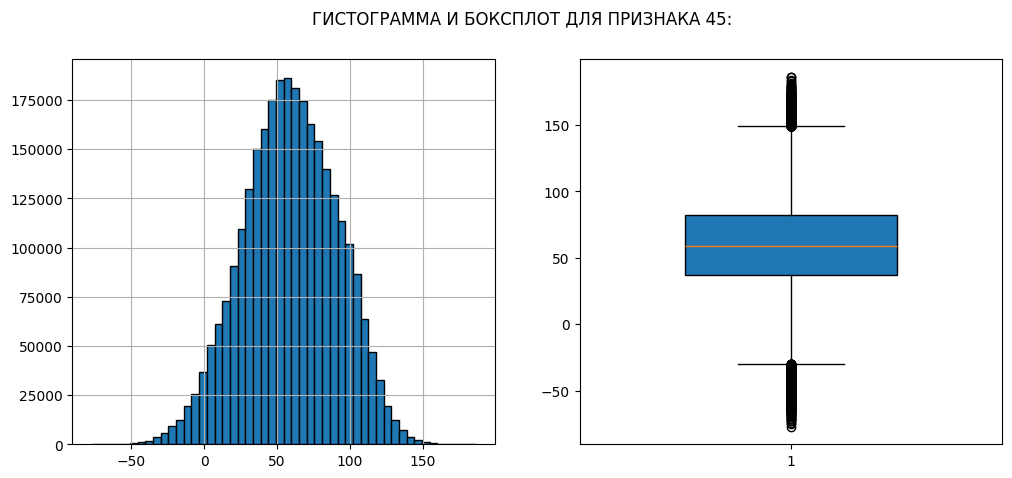

Пороговые значения признака 45:
Нижняя граница значений: -30.35
Верхняя граница значений: 149.23


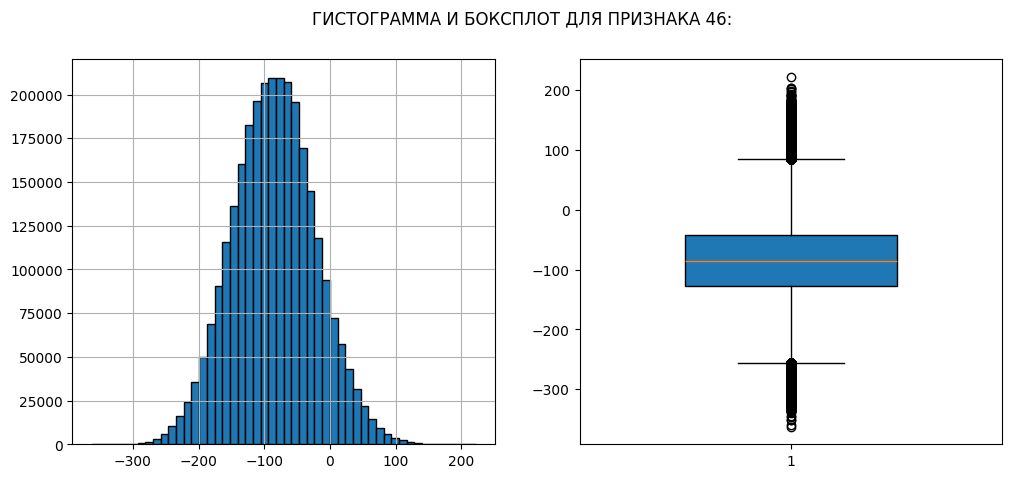

Пороговые значения признака 46:
Нижняя граница значений: -255.98
Верхняя граница значений: 84.78


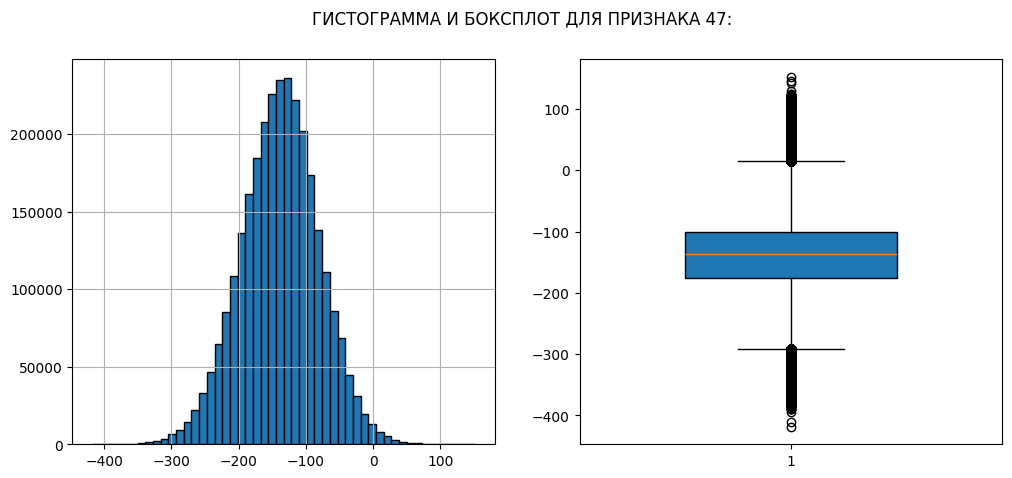

Пороговые значения признака 47:
Нижняя граница значений: -291.34
Верхняя граница значений: 14.64


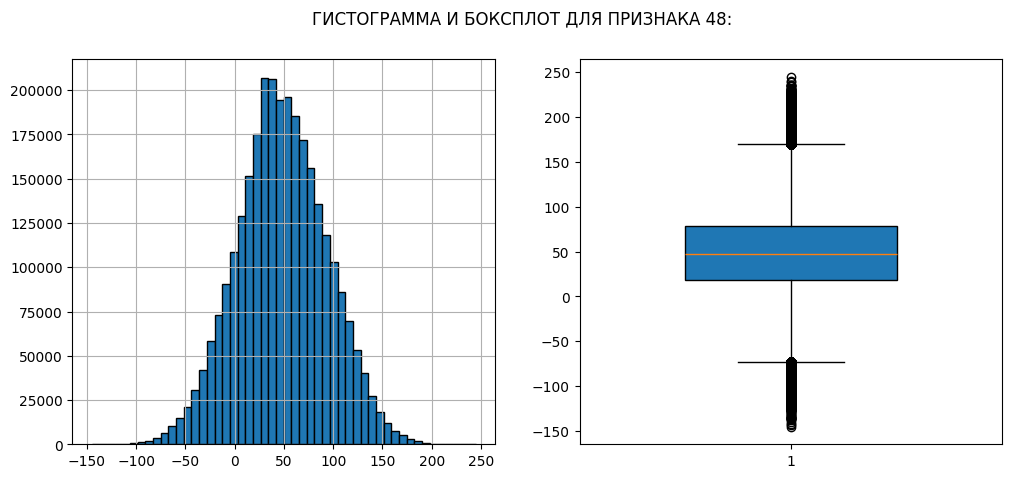

Пороговые значения признака 48:
Нижняя граница значений: -73.04
Верхняя граница значений: 169.48


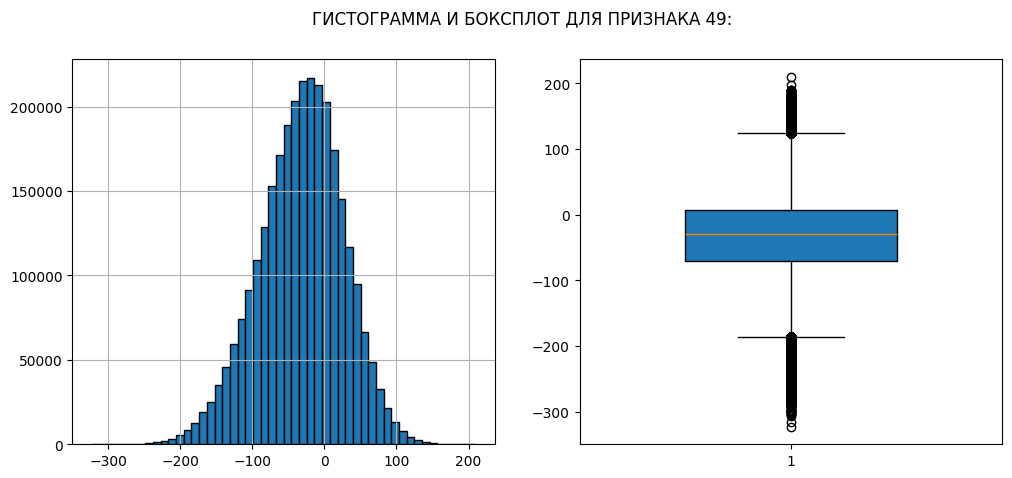

Пороговые значения признака 49:
Нижняя граница значений: -186.34
Верхняя граница значений: 124.04


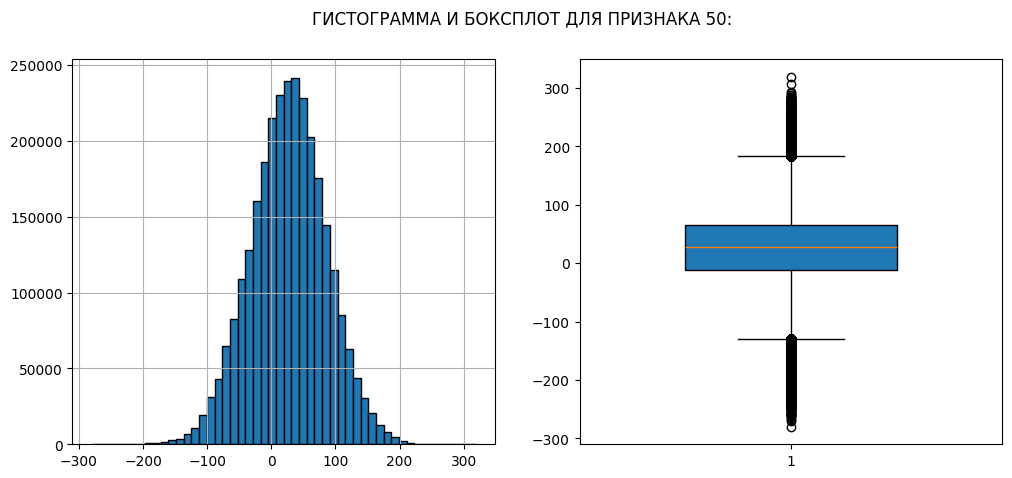

Пороговые значения признака 50:
Нижняя граница значений: -129.83
Верхняя граница значений: 183.5


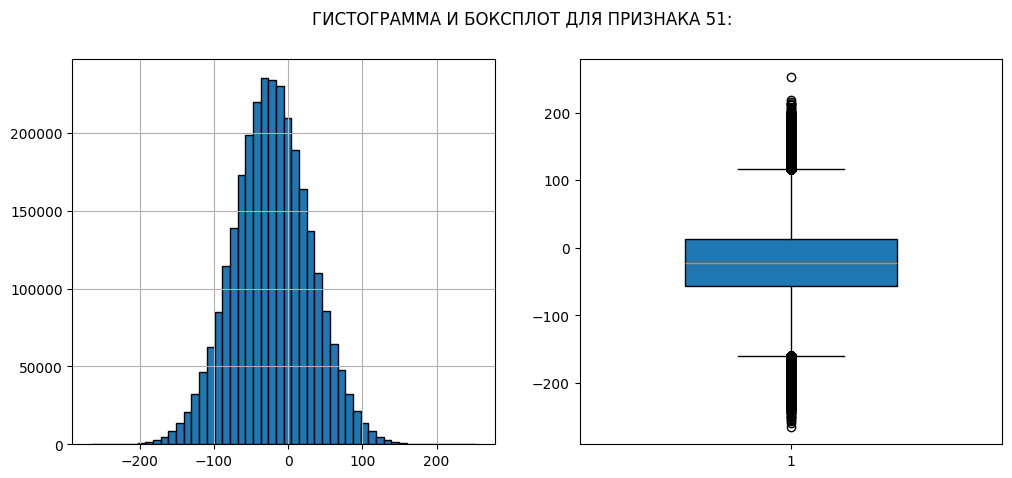

Пороговые значения признака 51:
Нижняя граница значений: -159.93
Верхняя граница значений: 116.47


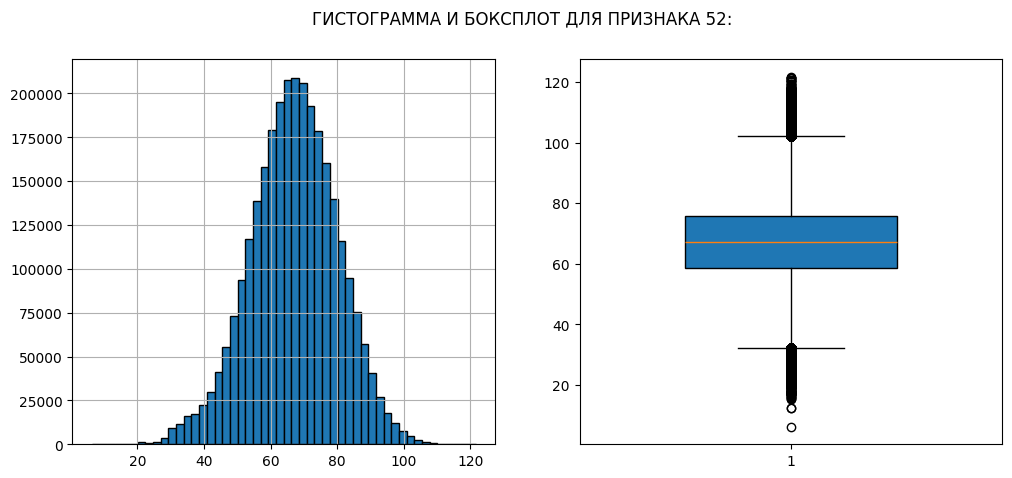

Пороговые значения признака 52:
Нижняя граница значений: 32.31
Верхняя граница значений: 102.05


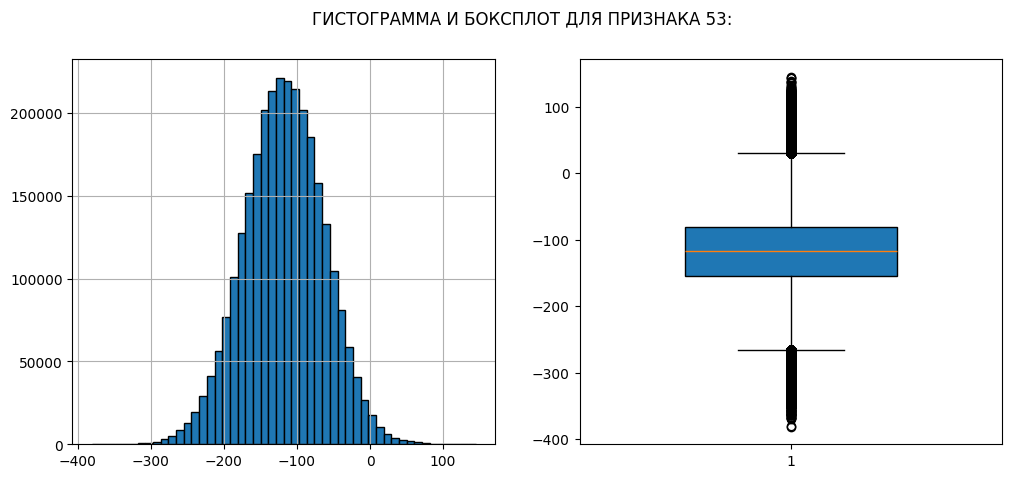

Пороговые значения признака 53:
Нижняя граница значений: -265.26
Верхняя граница значений: 30.14


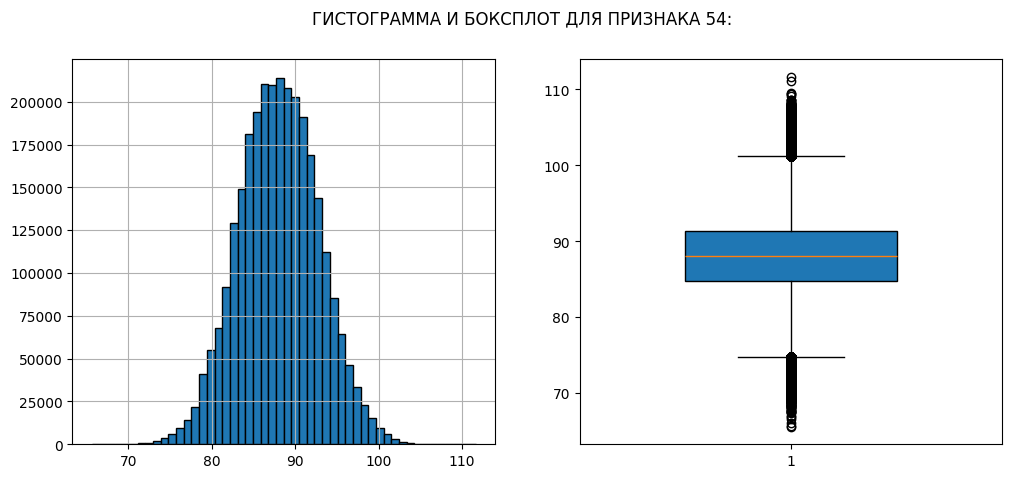

Пороговые значения признака 54:
Нижняя граница значений: 74.82
Верхняя граница значений: 101.21


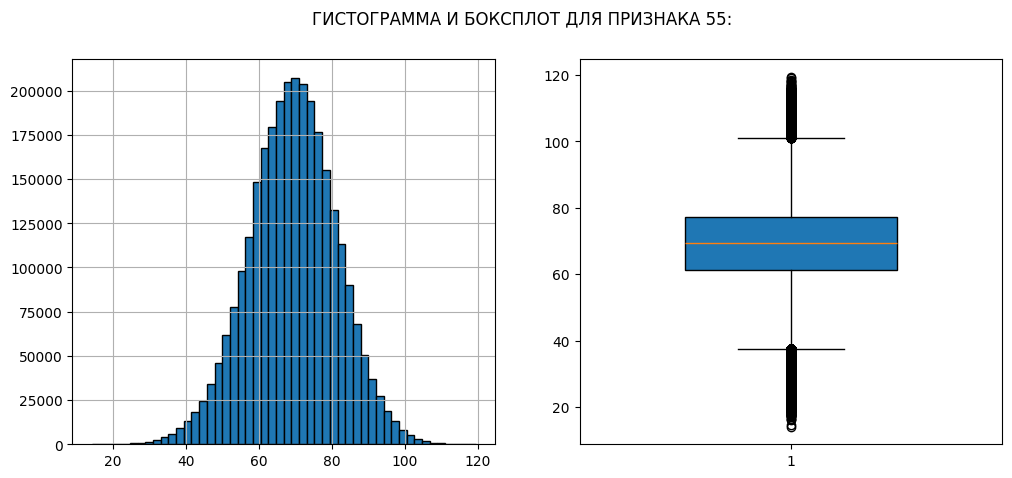

Пороговые значения признака 55:
Нижняя граница значений: 37.4
Верхняя граница значений: 101.15


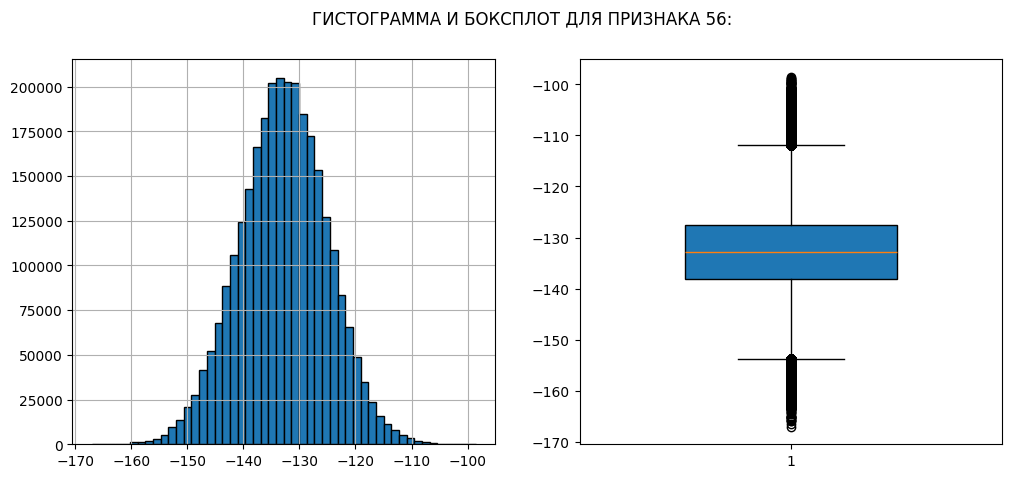

Пороговые значения признака 56:
Нижняя граница значений: -153.84
Верхняя граница значений: -111.88


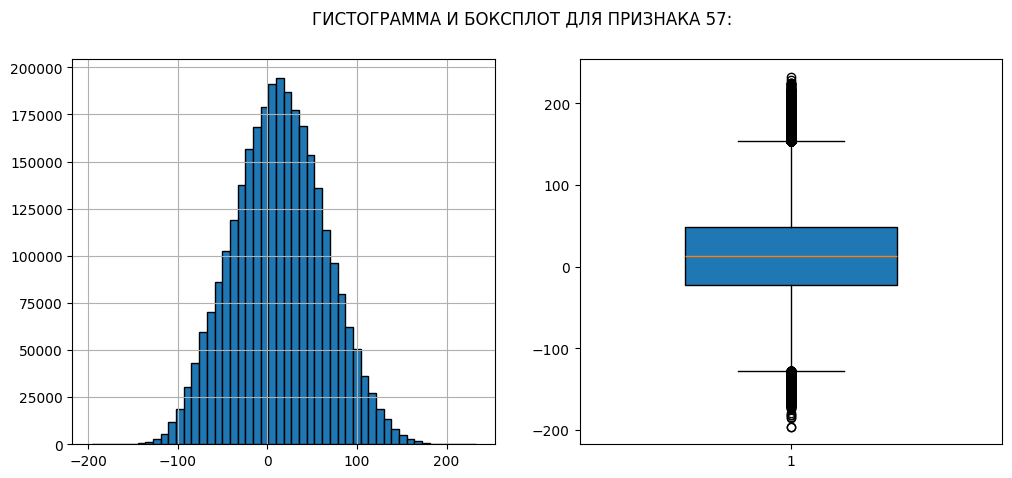

Пороговые значения признака 57:
Нижняя граница значений: -128.2
Верхняя граница значений: 153.97


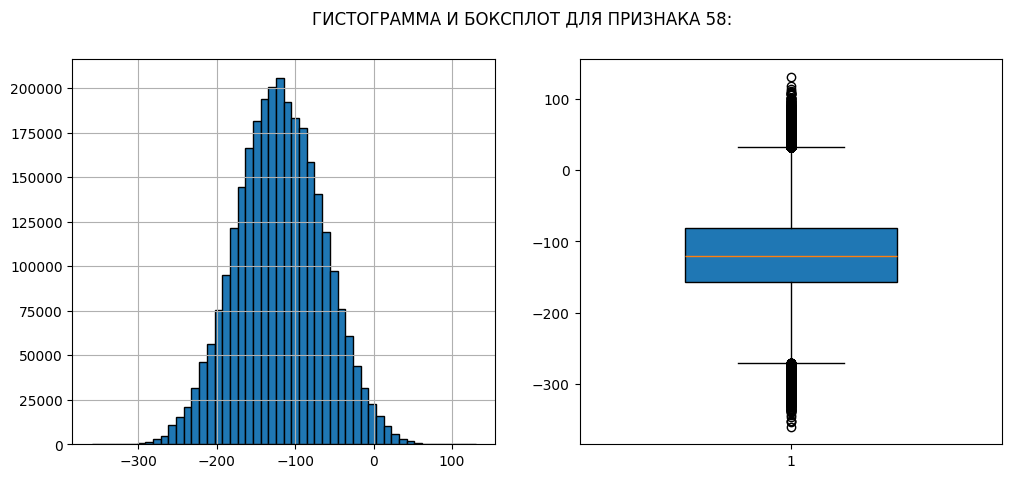

Пороговые значения признака 58:
Нижняя граница значений: -271.02
Верхняя граница значений: 31.88


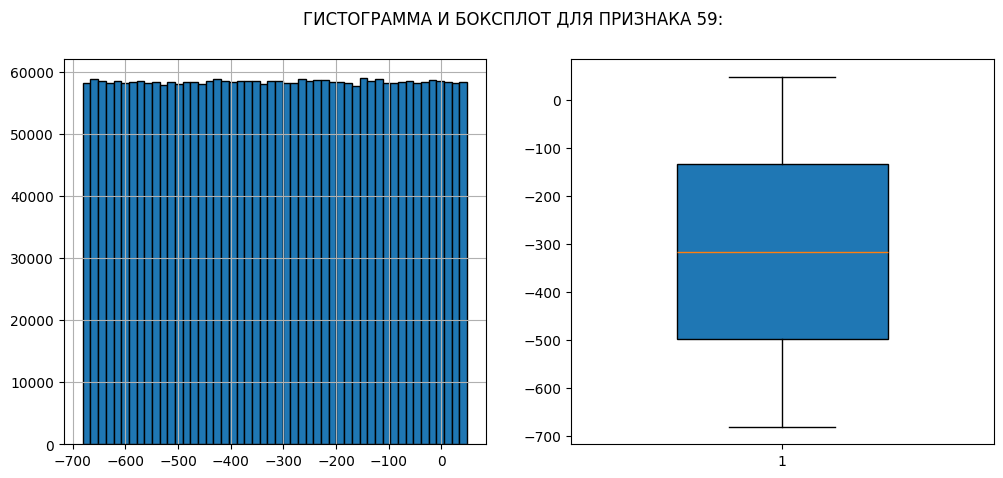

Пороговые значения признака 59:
Нижняя граница значений: -1045.79
Верхняя граница значений: 413.7


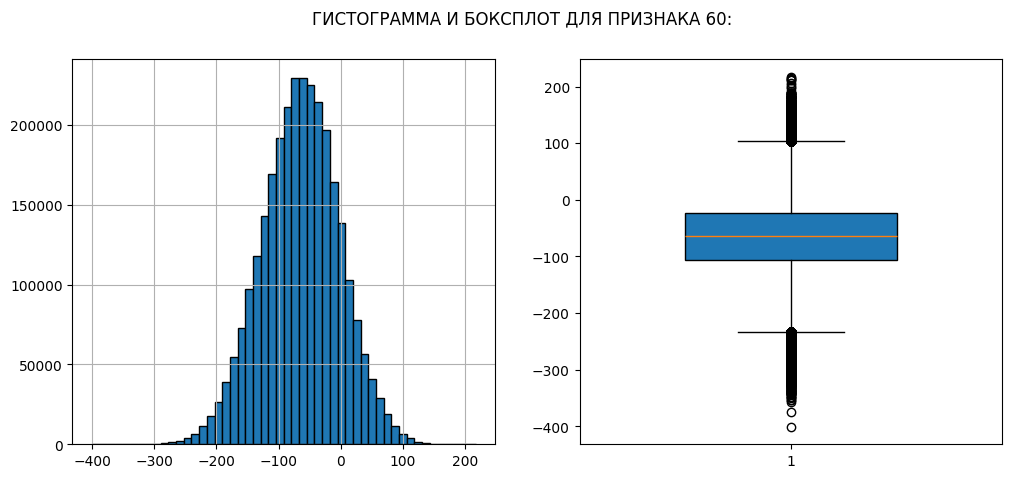

Пороговые значения признака 60:
Нижняя граница значений: -232.58
Верхняя граница значений: 103.5


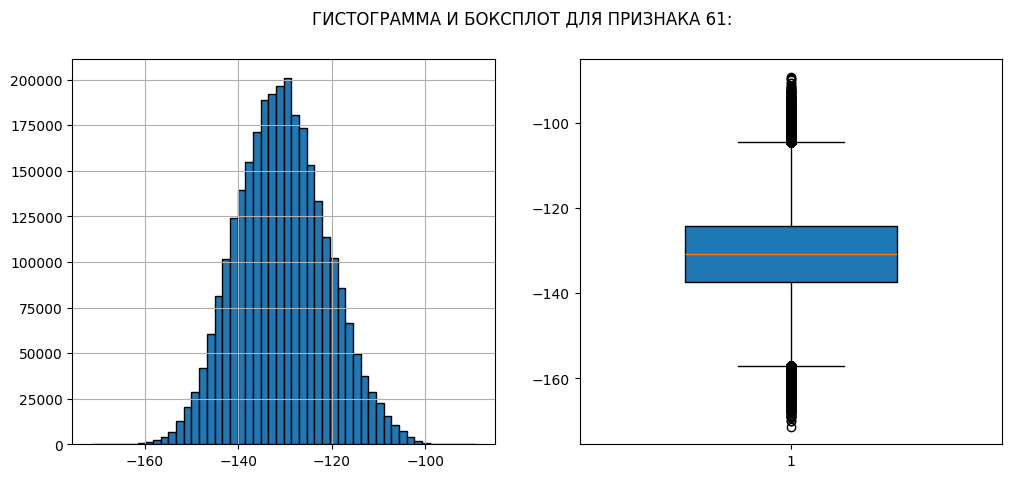

Пороговые значения признака 61:
Нижняя граница значений: -157.07
Верхняя граница значений: -104.58


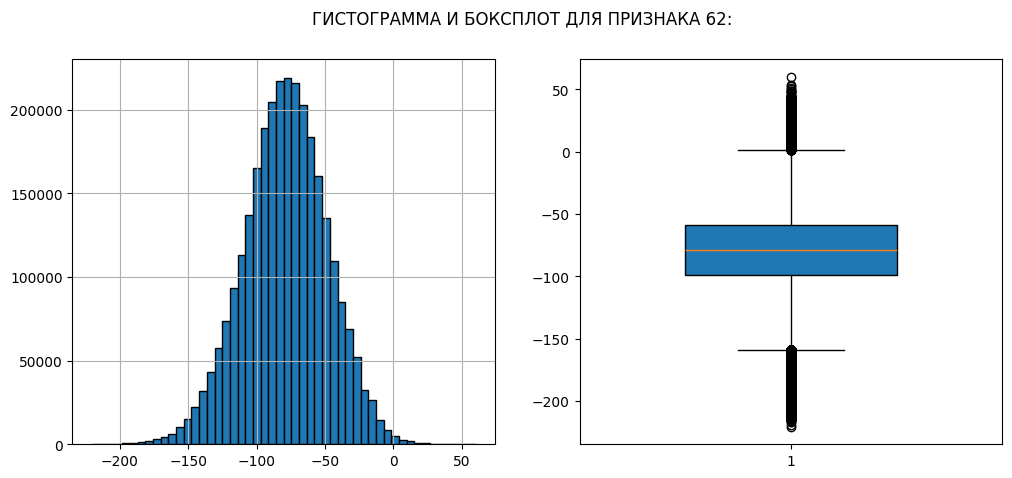

Пороговые значения признака 62:
Нижняя граница значений: -159.11
Верхняя граница значений: 1.81


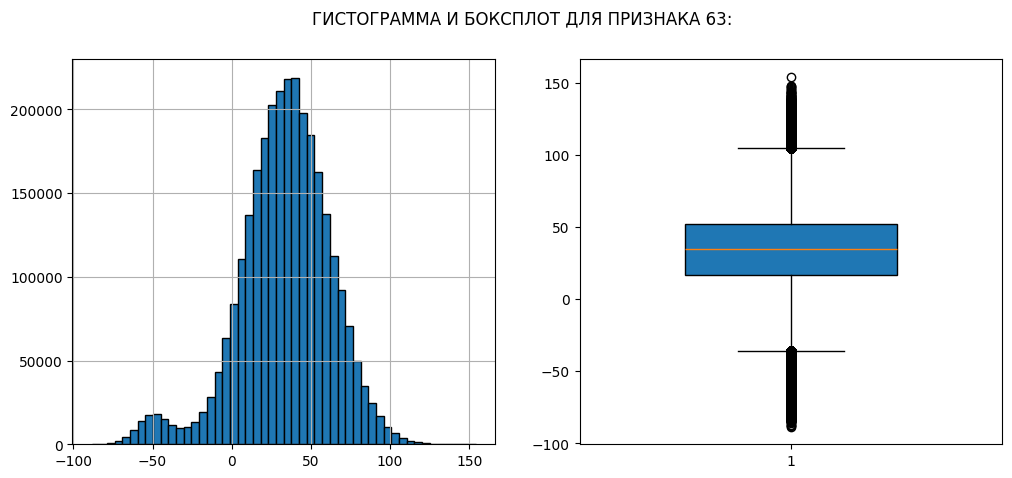

Пороговые значения признака 63:
Нижняя граница значений: -35.77
Верхняя граница значений: 104.93


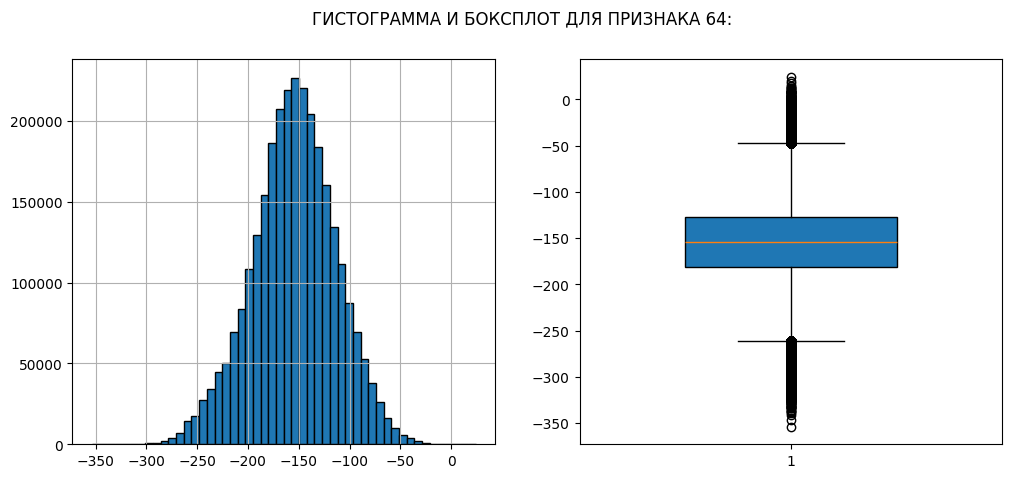

Пороговые значения признака 64:
Нижняя граница значений: -260.94
Верхняя граница значений: -47.18


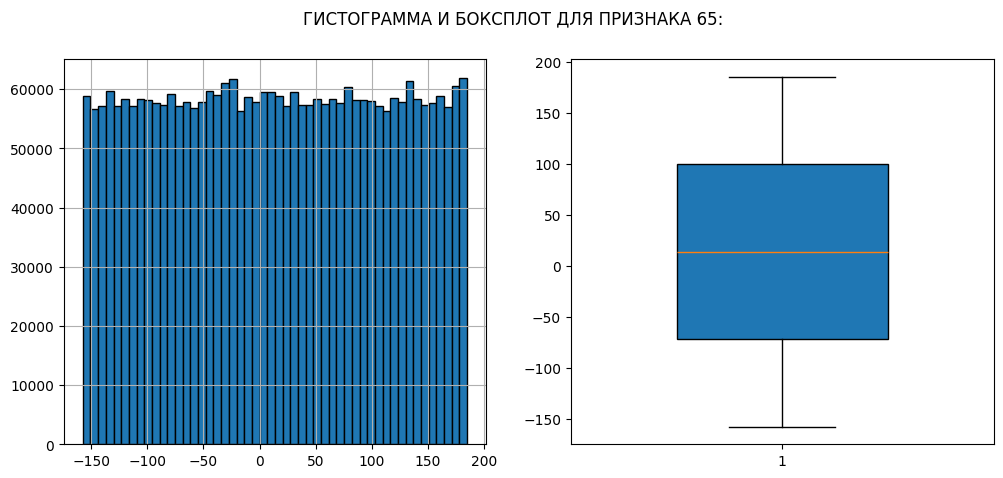

Пороговые значения признака 65:
Нижняя граница значений: -327.75
Верхняя граница значений: 356.12


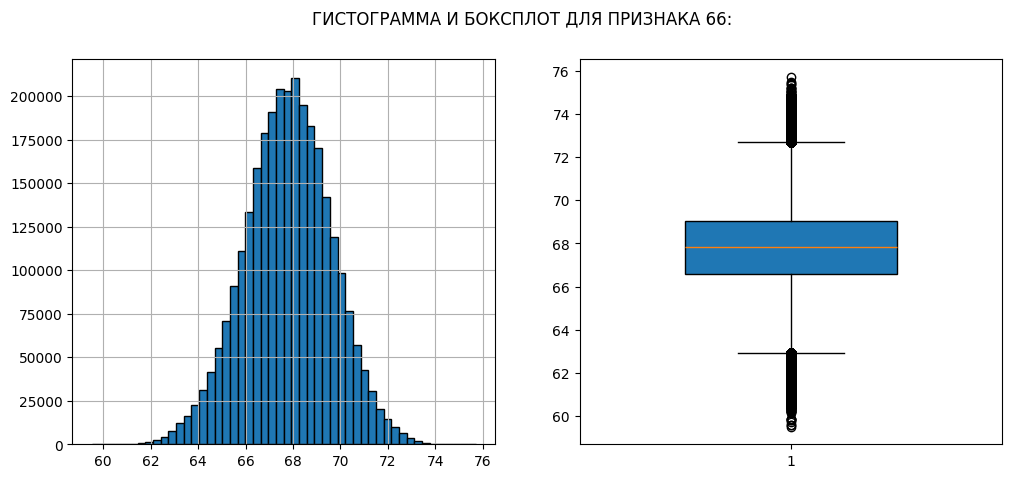

Пороговые значения признака 66:
Нижняя граница значений: 62.91
Верхняя граница значений: 72.7


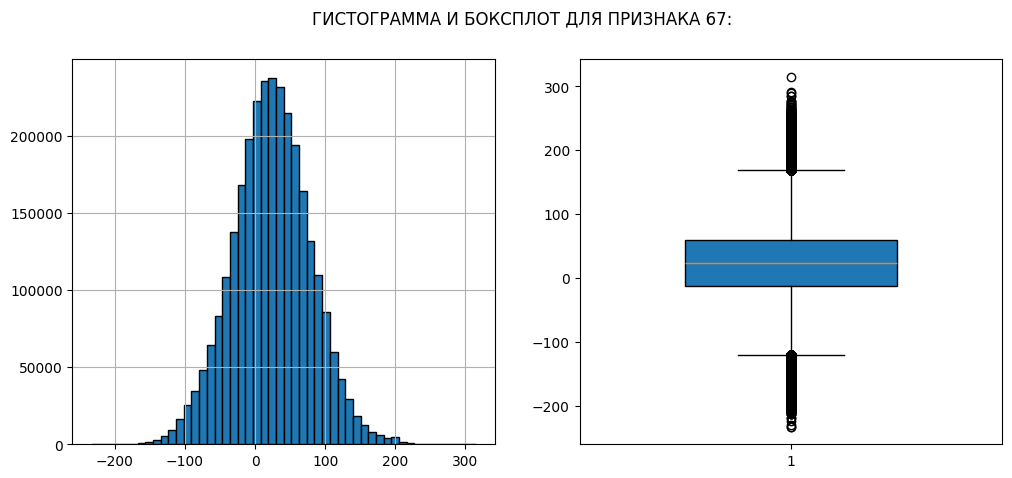

Пороговые значения признака 67:
Нижняя граница значений: -120.92
Верхняя граница значений: 168.16


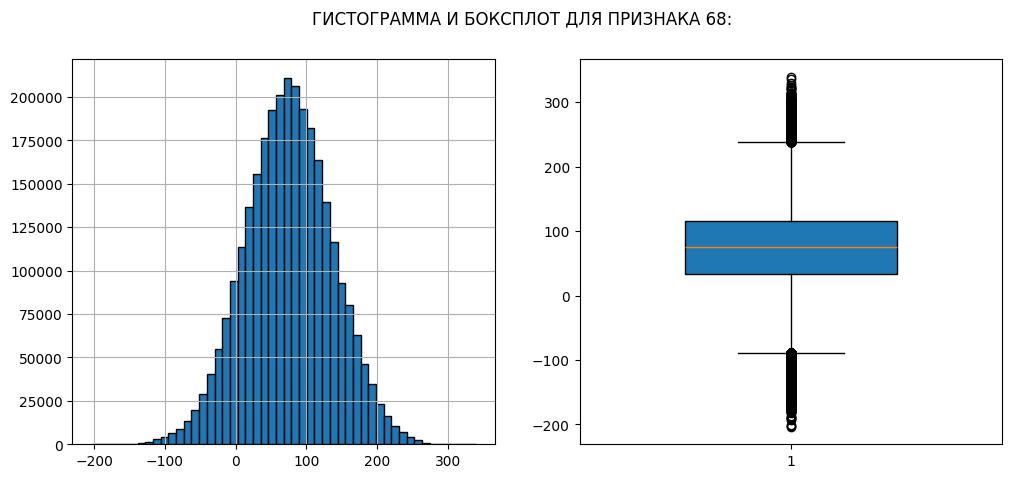

Пороговые значения признака 68:
Нижняя граница значений: -89.37
Верхняя граница значений: 239.03


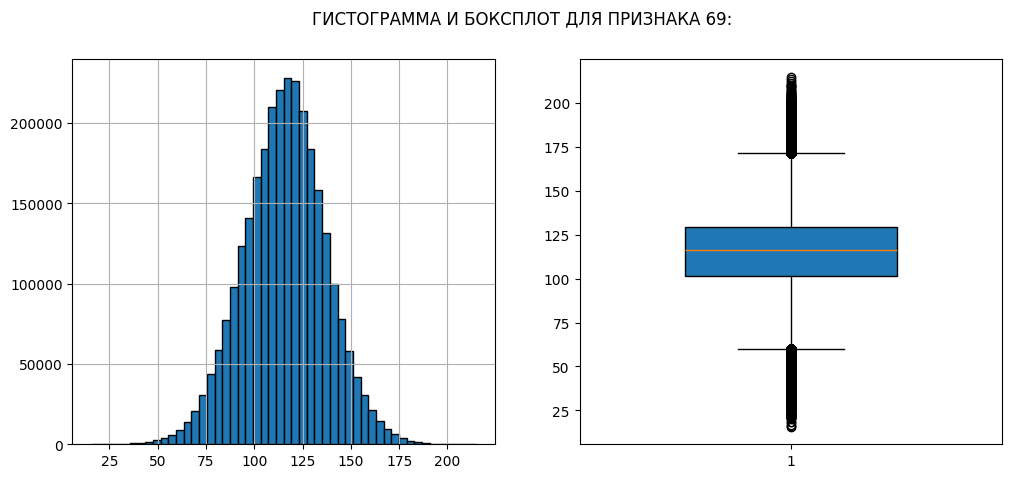

Пороговые значения признака 69:
Нижняя граница значений: 59.89
Верхняя граница значений: 171.35


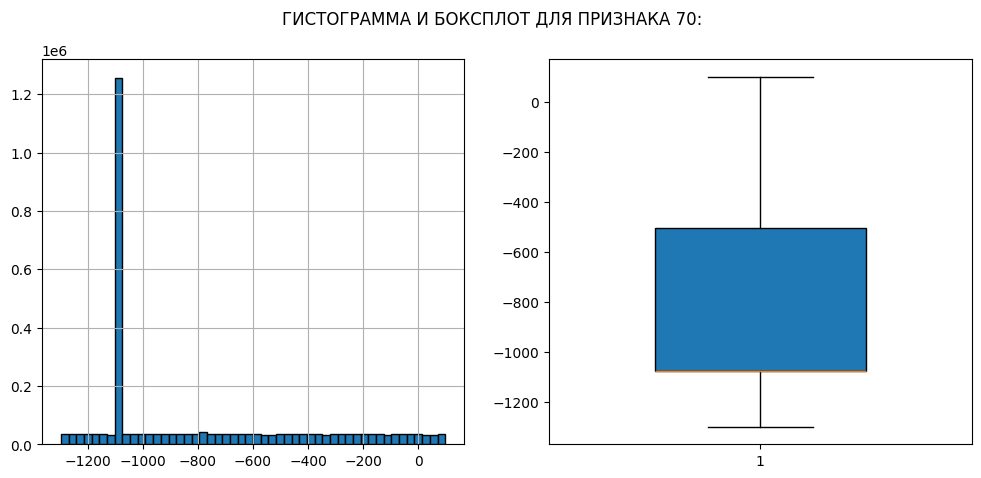

Пороговые значения признака 70:
Нижняя граница значений: -1927.55
Верхняя граница значений: 347.34


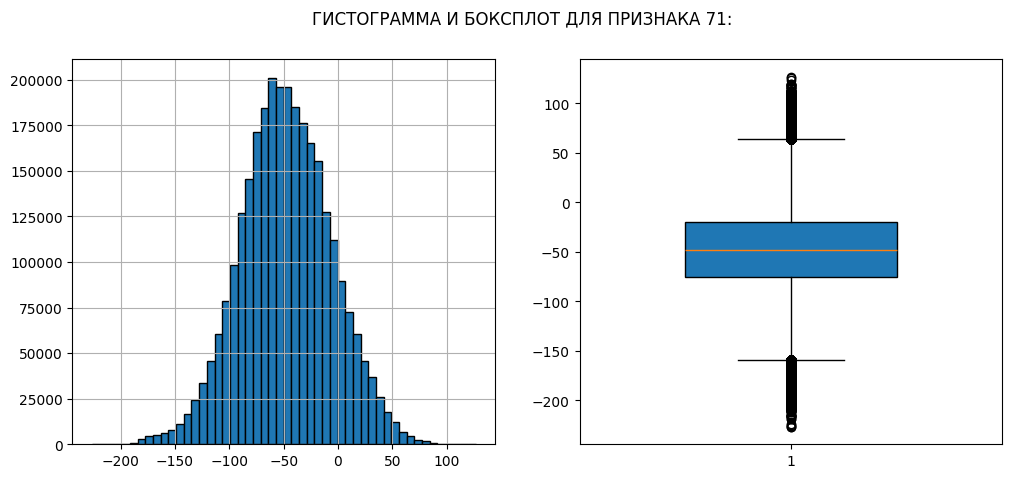

Пороговые значения признака 71:
Нижняя граница значений: -159.59
Верхняя граница значений: 64.21


In [155]:
def two_graf(data_train, name, bins):
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'ГИСТОГРАММА И БОКСПЛОТ ДЛЯ ПРИЗНАКА {name}:')
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    data_train.plot(
        kind='hist', 
        bins=bins, 
        grid=True, 
        edgecolor='black',
        ax=plt.gca()  # Используем текущую ось для гистограммы
    )
    plt.ylabel('')
    plt.xlabel('') 
    
    # Боксплот
    plt.subplot(1, 2, 2)
    plt.boxplot(
        x=data_train, vert=True, widths=0.5,
        patch_artist=True 
    )
    plt.show()
    
    # Вычисление пороговых значений
    z1 = data_train.quantile(0.25)
    z3 = data_train.quantile(0.75)
    r = z3 - z1
    lower = z1 - (1.5 * r)
    upper = z3 + (1.5 * r)
    
    # Печать пороговых значений
    print(f'Пороговые значения признака {name}:')
    print('Нижняя граница значений:', lower.round(2))
    print('Верхняя граница значений:', upper.round(2))


for j in df_base:
    two_graf(df_base[j], j, 50)

- Признак 6 - однородное распределение с двумя высокими пиками, без выбросов.
- Признаки 21 и 25 - однородное распределение с одним высоким пиком. Значения вне пика, отображены как выбросы.
- Признак 33 - присутствует много неоднородных пиков, без выбросов.
- Признак 44 - однородное распределение с одним высоким пиком и неколькими пиками пониже, без выбросов.
- Признаки 59 и 65 - однородное распределение без выбросов.
- Признак 70 - однородное распределение с одним высоким пиком, без выбросов.


**Вывод**\
\
В этом разделе были изучены предоставленные данные. Пропущенные значения и дубликаты в датасетах не обнаружены. Признаки между собой коррелируют слабо. В датасете присутствуют признаков с высокой мультиколлинеарностью. Гистограммы показали, что большая часть признаков имеет нормальное распределение.\
Большая часть признаков с выбросами. Исключения составляют следующие признаки: 6, 33 , 44, 59, 65, 70.

Далее попробуем ускорить работу алгоритма и поднять оценку метрики.


1 этап обучения

In [156]:
targets_train = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [157]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,-146.517075,-159.469849,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789322,-78.737091,1507.231323,19.957405,34.834290,-8.820732,813.770081,-125.606796,17.584084,-58.452904,141.281799,-54.959309,-136.988541,63.880493,-1018.469543,89.228928,65.919960,-24.078644,-152.334106,-91.199379,-28.225389,-4.767386,0.158236,-129.128662,122.958366,-30.800995,123.623398,-37.540867,-72.139801,71.240990,-168.115585,118.236450,-18.065195,37.255718,-137.691040,87.500771,62.437290,-131.260635,35.692661,-86.038834,-379.339081,-153.465775,-131.198288,-61.567047,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,-107.153023,-8.800034,-50.977798,29.457338,143.389313,5.614824,-45.274761,9.643625,-77.554626,-79.066612,-77.926460,1507.231323,16.612400,116.284286,33.754898,813.770081,-105.765335,6.523008,-19.812988,157.693924,-20.604088,-146.591278,78.849571,-780.449158,87.560768,73.036659,16.891029,-144.657898,-116.122147,-19.353254,-7.709266,-5.394988,-140.252121,193.184967,-53.147079,79.869446,-151.131348,-45.056160,79.796234,46.76301

In [158]:
scaler = RobustScaler()

df_base_scaler = scaler.fit_transform(df_base)
df_train_scaler = scaler.transform(df_train)

Сначала обучим данные без предобработки и посмотрим что получится.

In [159]:
dims = df_base_scaler.shape[1] # размер индексных векторов
n_cells = 20 #количество кластеров
quantizer = faiss.IndexFlatL2(dims) # индекс для присвоения векторов определенному кластеру
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [160]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_scaler).astype('float32'))

CPU times: total: 5.38 s
Wall time: 1.27 s


In [161]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [162]:
%%time
candidate_number = 5
r, idx = idx_l2.search(np.ascontiguousarray(df_train_scaler).astype('float32'), candidate_number)

CPU times: total: 21min 5s
Wall time: 1min 3s


In [163]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

44.224


Дальше попробуем улучшить метрику.

## Удаление признаков с ненормальным распределением(6, 21, 25, 33, 44, 59, 65, 70).

Сначала удалим признаки с наоболее подозрительным распределение, а дальше будем смотреть как повлияет на метрику удаление оставшихся признаков.
- Удалим признаки: 21 и 25 с высоким пиком и выбросами вне него, 33 с множеством пиков, 70 с высоким пиком, но приэтом без выбросов.
- Удалим признаки 59 и 65
- Удалим признаки 6 и 44

In [164]:
df_base_del_1 = df_base.drop(['21', '25', '33', '70'], axis=1)
df_train_del_1 = df_train.drop(['21', '25', '33', '70'], axis=1)

In [165]:
df_base_del_1_scaler = scaler.fit_transform(df_base_del_1)
df_train_del_1_scaler = scaler.transform(df_train_del_1)

In [166]:
dims = df_base_del_1_scaler.shape[1]
n_cells = 20
quantizer_del_1 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_1, dims, n_cells)

In [167]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_1_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_1_scaler).astype('float32'))

CPU times: total: 6.2 s
Wall time: 1.05 s


In [168]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_1_scaler).astype('float32'), candidate_number)

CPU times: total: 16min 43s
Wall time: 47.5 s


In [169]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))


62.082


После удаления первых признаков accuracy@5 значительно улучшилась и стала 62.082

In [170]:
df_base_del_2 = df_base.drop(['21', '25', '33', '59', '65', '70'], axis=1)
df_train_del_2 = df_train.drop(['21', '25', '33', '59', '65', '70'], axis=1)

In [171]:
df_base_del_2_scaler = scaler.fit_transform(df_base_del_2)
df_train_del_2_scaler = scaler.transform(df_train_del_2)

In [172]:
dims = df_base_del_2_scaler.shape[1]
n_cells = 20
quantizer_del_2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_2, dims, n_cells)

In [173]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_2_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_2_scaler).astype('float32'))

CPU times: total: 5.59 s
Wall time: 1.02 s


In [174]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_2_scaler).astype('float32'), candidate_number)

CPU times: total: 15min 4s
Wall time: 44.5 s


In [175]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

63.311


После удаления признаков 59 и 65 метрика еще немного возросла

In [176]:
df_base_del_3 = df_base.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
df_train_del_3 = df_train.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)

In [177]:
df_base_del_3_scaler = scaler.fit_transform(df_base_del_3)
df_train_del_3_scaler = scaler.transform(df_train_del_3)

In [178]:
dims = df_base_del_3_scaler.shape[1]
n_cells = 20
quantizer_del_3 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_3, dims, n_cells)

In [179]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_3_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_3_scaler).astype('float32'))

CPU times: total: 5.62 s
Wall time: 1.01 s


In [180]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_3_scaler).astype('float32'), candidate_number)

CPU times: total: 14min 37s
Wall time: 42.9 s


In [181]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

63.122


После удаления признаков 6 и 44 метрика ухуджилась, не будем их удалять.

## Удаление мультиколлинеарных признаков

Рассмотрим как повлияет на метрику удаление признаков с очень высокими значениями VIF(>1000)  и с высокими значениями VIF(100 < VIF < 1000).

In [182]:
df_base_del_2_1 = df_base_del_2.drop(['19', '66'], axis=1)
df_train_del_2_1 = df_train_del_2.drop(['19', '66'], axis=1)

In [183]:
df_base_del_2_1_scaler = scaler.fit_transform(df_base_del_2_1)
df_train_del_2_1_scaler = scaler.transform(df_train_del_2_1)

In [184]:
dims = df_base_del_2_1_scaler.shape[1]
n_cells = 20
quantizer_del_2_1 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_2_1, dims, n_cells)

In [185]:
idx_l2.train(np.ascontiguousarray(df_base_del_2_1_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_2_1_scaler).astype('float32'))

In [186]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_2_1_scaler).astype('float32'), candidate_number)

CPU times: total: 15min 8s
Wall time: 48.6 s


In [187]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

63.142


In [188]:
df_base_del_2_2 = df_base_del_2.drop(['19', '66', '8', '54', '56', '29', '37', '61'], axis=1)
df_train_del_2_2 = df_train_del_2.drop(['19', '66', '8', '54', '56', '29', '37', '61'], axis=1)

In [189]:
df_base_del_2_2_scaler = scaler.fit_transform(df_base_del_2_2)
df_train_del_2_2_scaler = scaler.transform(df_train_del_2_2)

In [190]:
dims = df_base_del_2_2_scaler.shape[1]
n_cells = 20
quantizer_del_2_2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_2_2, dims, n_cells)

In [191]:
idx_l2.train(np.ascontiguousarray(df_base_del_2_2_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_2_2_scaler).astype('float32'))

In [192]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_2_2_scaler).astype('float32'), candidate_number)

CPU times: total: 14min 9s
Wall time: 45.2 s


In [193]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

62.521


Метрика ухудшилась, не будем удалять эти признаки.

## Поиск оптимального количества кластеров

Определим оптимальное количество кластеров по методу "локтя".

In [194]:
def cluster_count(df, a, b, c):  
    inertia = []
    for k in range(a,b,c):
        mbk  = KMeans(n_clusters=k, init='random', random_state=12345).fit(df)
        inertia.append(np.sqrt(mbk.inertia_))
        
    plt.figure(figsize=(20,15))
    plt.plot(range(a,b,c),inertia,marker='s', color = '#35c0cd')
    plt.xlabel('ЧИСЛО КЛАСТЕРОВ')
    plt.ylabel('ЗНАЧЕНИЕ ЦЕЛЕВОЙ ФУНКЦИИ');
    plt.show()

In [195]:
mini_base = np.ascontiguousarray(df_base_del_2_scaler[:60000, :])

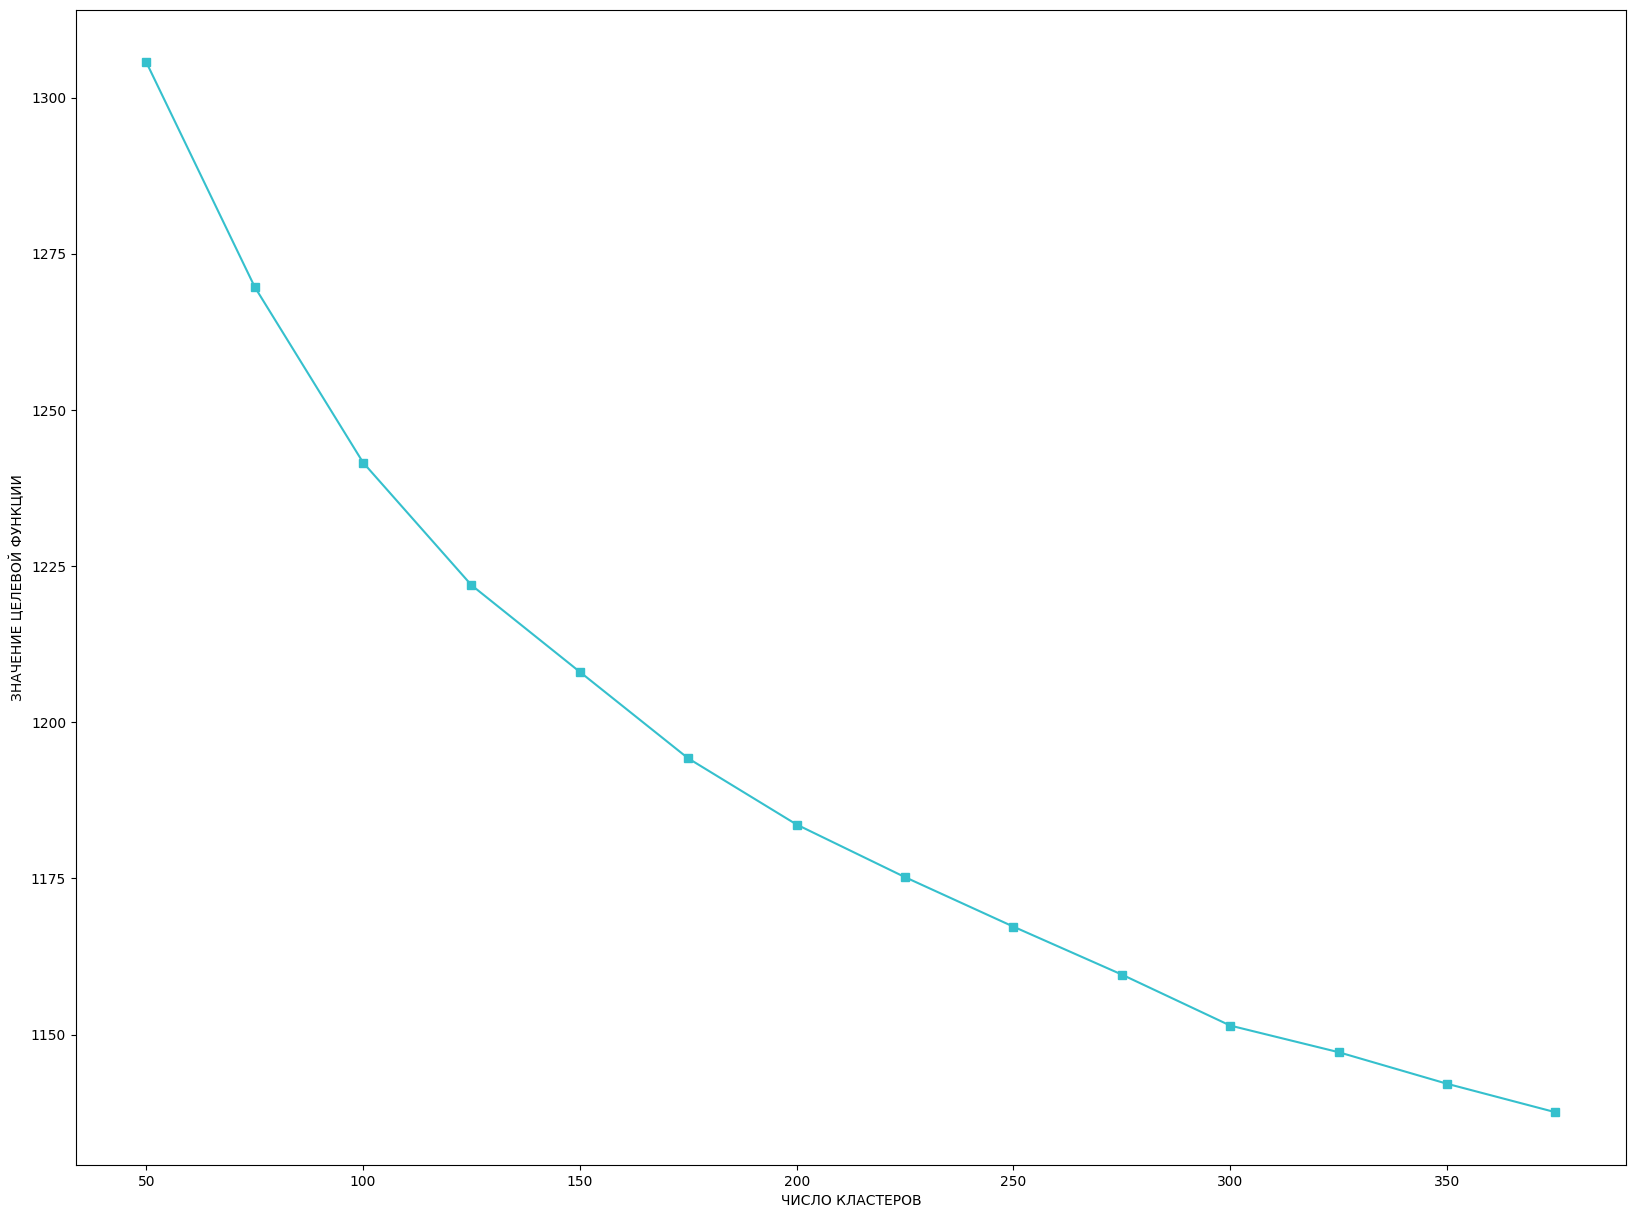

In [196]:
cluster_count(mini_base, 50, 400, 25)

Однозначно определить лучшее количество кластеров трудно, возьмем значения 50, 100, 200, 300.

Создадим функцию для определения accuracy@5 при различных значениях параметров.

In [197]:
K = 5
def faiss_accuracy(df, df_eval, target,
                  n_clust=None,
                  index='ivf_flat',
                  metric='euclidean',
                  train_sample_size=None,
                  ef_search=32,
                  k_similar = K,
                  scaler=RobustScaler(),
                  SEED=99):
    
    scaler = scaler
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    df_eval = pd.DataFrame(scaler.transform(df_eval), columns=df_eval.columns, index=df_eval.index)
    
    dims = df.shape[1]
    base_index = {k: v for k, v in enumerate(df.index.to_list())}
    
    if index == 'ivf_flat':
        quantizer = faiss.IndexFlatL2(dims)
        df_arr = np.ascontiguousarray(df.values)
        df_eval_arr = np.ascontiguousarray(df_eval.values)
                        
        if metric == 'mahalanobis':
                
            # Вычислим матрицу ковариации.
            df_c = df - df.mean(0)
            cov = np.dot(df_c.T, df_c) / df_c.shape[0]

            # Преобразуем ковариационную матрицу.
            L = np.linalg.cholesky(cov)
            mahalanobis_transform = np.linalg.inv(L)

            # Функция преобразования данных.
            def inverse_cholesky_cov(df, mahalanobis_transform):
                df_trans = np.dot(df, mahalanobis_transform.T)
                return df_trans

            # Преобразуем данные.
            df_arr = inverse_cholesky_cov(df, mahalanobis_transform)
            df_eval_arr = inverse_cholesky_cov(df_eval, mahalanobis_transform)

            # Определим индекс.
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust, faiss.METRIC_L2)
        
                
        elif metric == 'cosine':
            faiss.normalize_L2(df_arr)
            faiss.normalize_L2(df_eval_arr)
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust, faiss.METRIC_INNER_PRODUCT)
            
            
        elif metric == 'mips':
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust, faiss.METRIC_INNER_PRODUCT)
        
        elif metric == 'euclidean':
            index = faiss.IndexIVFFlat(quantizer, dims, n_clust)
            
        else:
            raise ValueError('Метрика не поддерживается или не существует')
    
    elif index == 'ivf_hnsw':
        df_arr = np.ascontiguousarray(df.values)
        df_eval_arr = np.ascontiguousarray(df_eval.values)
        index = faiss.index_factory(dims, (f'IVF{n_clust}_HNSW'+f'{ef_search}'+',Flat'))
        index.nprobe = 8
        
    start_faiss = perf_counter()
    
    index.train(df_arr[:train_sample_size, :])
    index.add(df_arr)
    
    vecs, idx = index.search(df_eval_arr.astype('float32'), k_similar)
    
    acc = 0
    for tar, el in zip(target.values.tolist(), idx):
        acc += int(tar in [base_index[r] for r in el])

    time = perf_counter() - start_faiss
    
    return (round((100 * acc / len(idx)), 3), round(time, 3))

In [198]:
metrics_results = []

for index, n_clust, metric in product(
    ['ivf_flat', 'ivf_hnsw'],
    [50, 100, 200, 300],
    ['mahalanobis', 'cosine', 'mips', 'euclidean']
    ):

    acc, time = faiss_accuracy(df=df_base, df_eval=df_train, target=targets_train,
                  n_clust=n_clust,
                  metric=metric,
                  train_sample_size=int(df_base.shape[0] * 0.1),
                  scaler=RobustScaler()
                  )
    metrics_results.append([index, n_clust, metric, acc, time])

In [199]:
columns = ['Индекс', 'Количество кластеров', 'Метрика', 'accuracy@5', 'Время поиска, сек.']
df_metrics_results = pd.DataFrame(metrics_results, columns=columns)
df_metrics_results.sort_values('accuracy@5', ascending=False)

,Индекс,Количество кластеров,Метрика,accuracy@5,"Время поиска, сек."
0,ivf_flat,50,mahalanobis,55.854,21.141
16,ivf_hnsw,50,mahalanobis,55.854,24.247
8,ivf_flat,200,mahalanobis,55.289,6.976
24,ivf_hnsw,200,mahalanobis,55.289,7.435
20,ivf_hnsw,100,mahalanobis,55.117,13.470
4,ivf_flat,100,mahalanobis,55.117,12.541
28,ivf_hnsw,300,mahalanobis,54.458,5.266
12,ivf_flat,300,mahalanobis,54.458,5.013
5,ivf_flat,100,cosine,48.589,24.751
21,ivf_hnsw,100,cosine,48.589,26.608


Лучшее значение accuracy@5 и time достигается при следующих параметрах:
- индекс - ivf_hnsw
- количество кластеров - 50
- метрика - mahalanobis

## Оценка качества матчинга метрикой accuracy@5 на валидационной выборке.

In [200]:
df_valid_answer = pd.read_csv("validation_answer.csv", index_col=0, dtype=dict_base)
df_valid_answer.head(10)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base
100005-query,1905037-base
100006-query,306584-base
100007-query,1533713-base
100008-query,2796017-base


In [201]:
target_valid = df_valid_answer['Expected']

In [202]:
df_base = df_base.drop(['21', '25', '33', '59', '65', '70'], axis=1)
df_valid = df_valid.drop(['21', '25', '33', '59', '65', '70'], axis=1)

In [203]:
acc, time = faiss_accuracy(df=df_base, df_eval=df_valid, target=target_valid,
                  n_clust=50,
                  index='ivf_hnsw',
                  metric='mahalanobis',
                  train_sample_size=int(df_base.shape[0] * 0.1),
                  scaler=RobustScaler()
                  )
acc, time

(70.738, 194.486)

На валидационной выборке получили значение accuracy@5 равное 70.738 при времени работы 194.486 секунд.